In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import preliz as pz

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


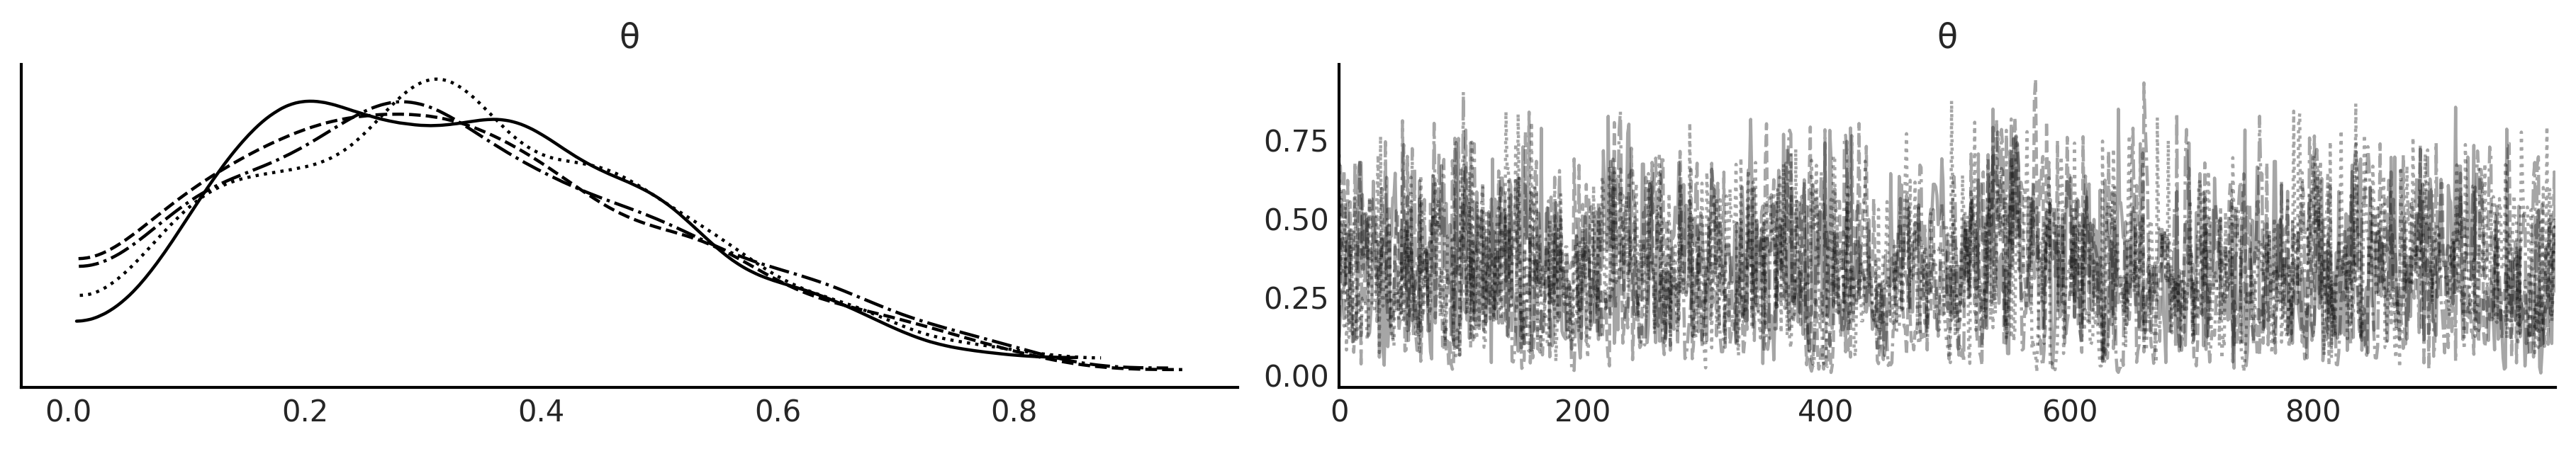

In [5]:
az.plot_trace(idata)
plt.savefig("../fig/idata_trace.png")

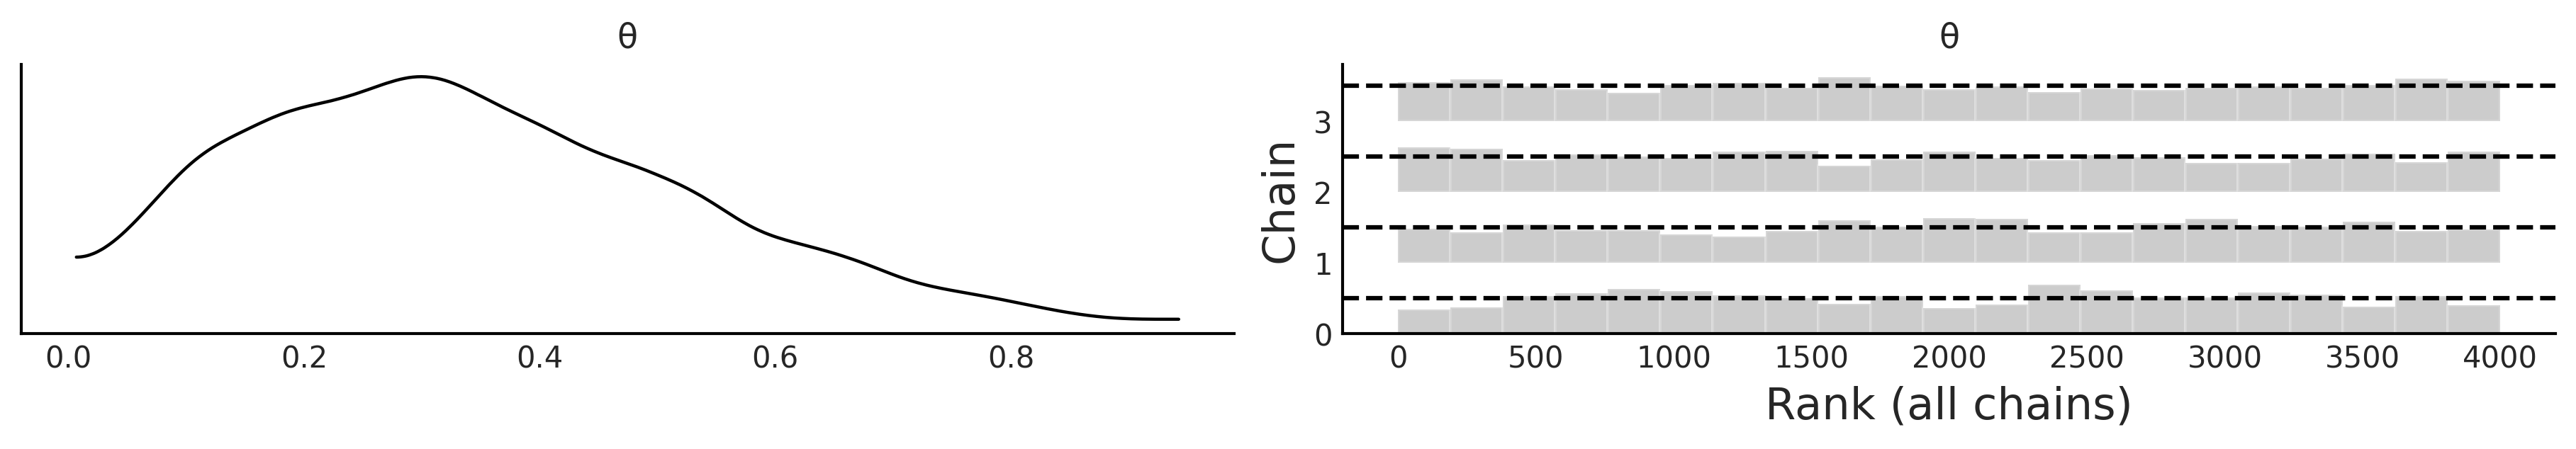

In [6]:
az.plot_trace(idata, kind="rank_bars", combined=True, rank_kwargs={"colors": "k"});
plt.savefig("../fig/idata_rank.png")

In [7]:
az.summary(idata, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
θ  0.34  0.18    0.03     0.66

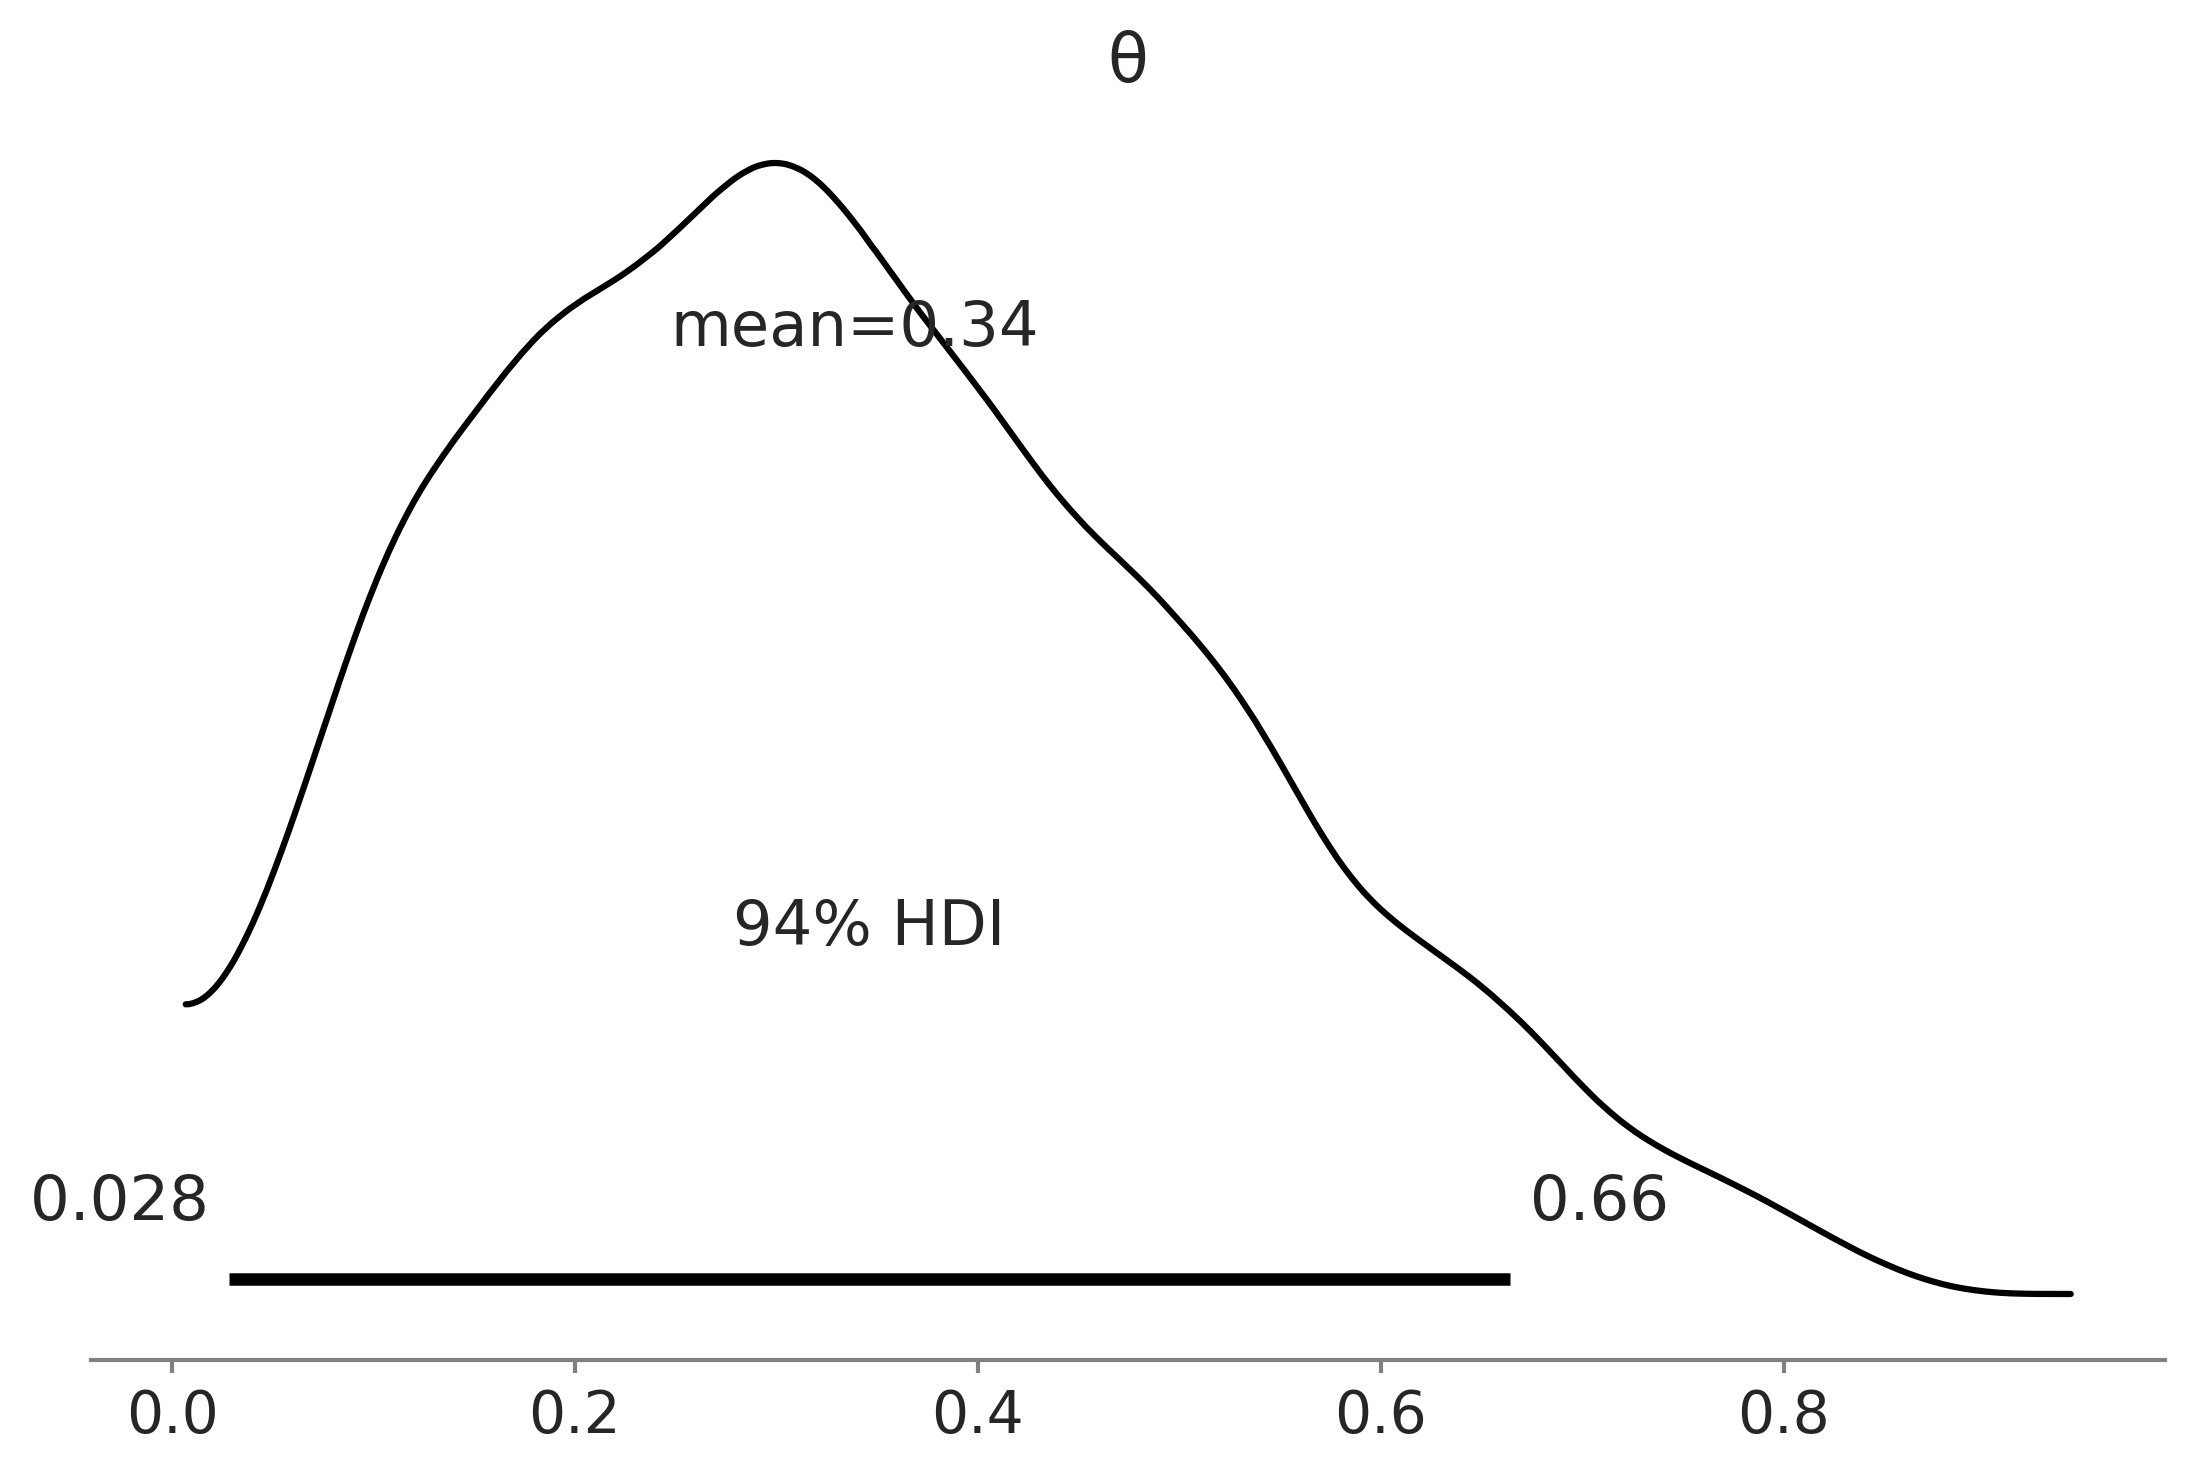

In [8]:
az.plot_posterior(idata)
plt.savefig("../fig/idata_posterior.png")

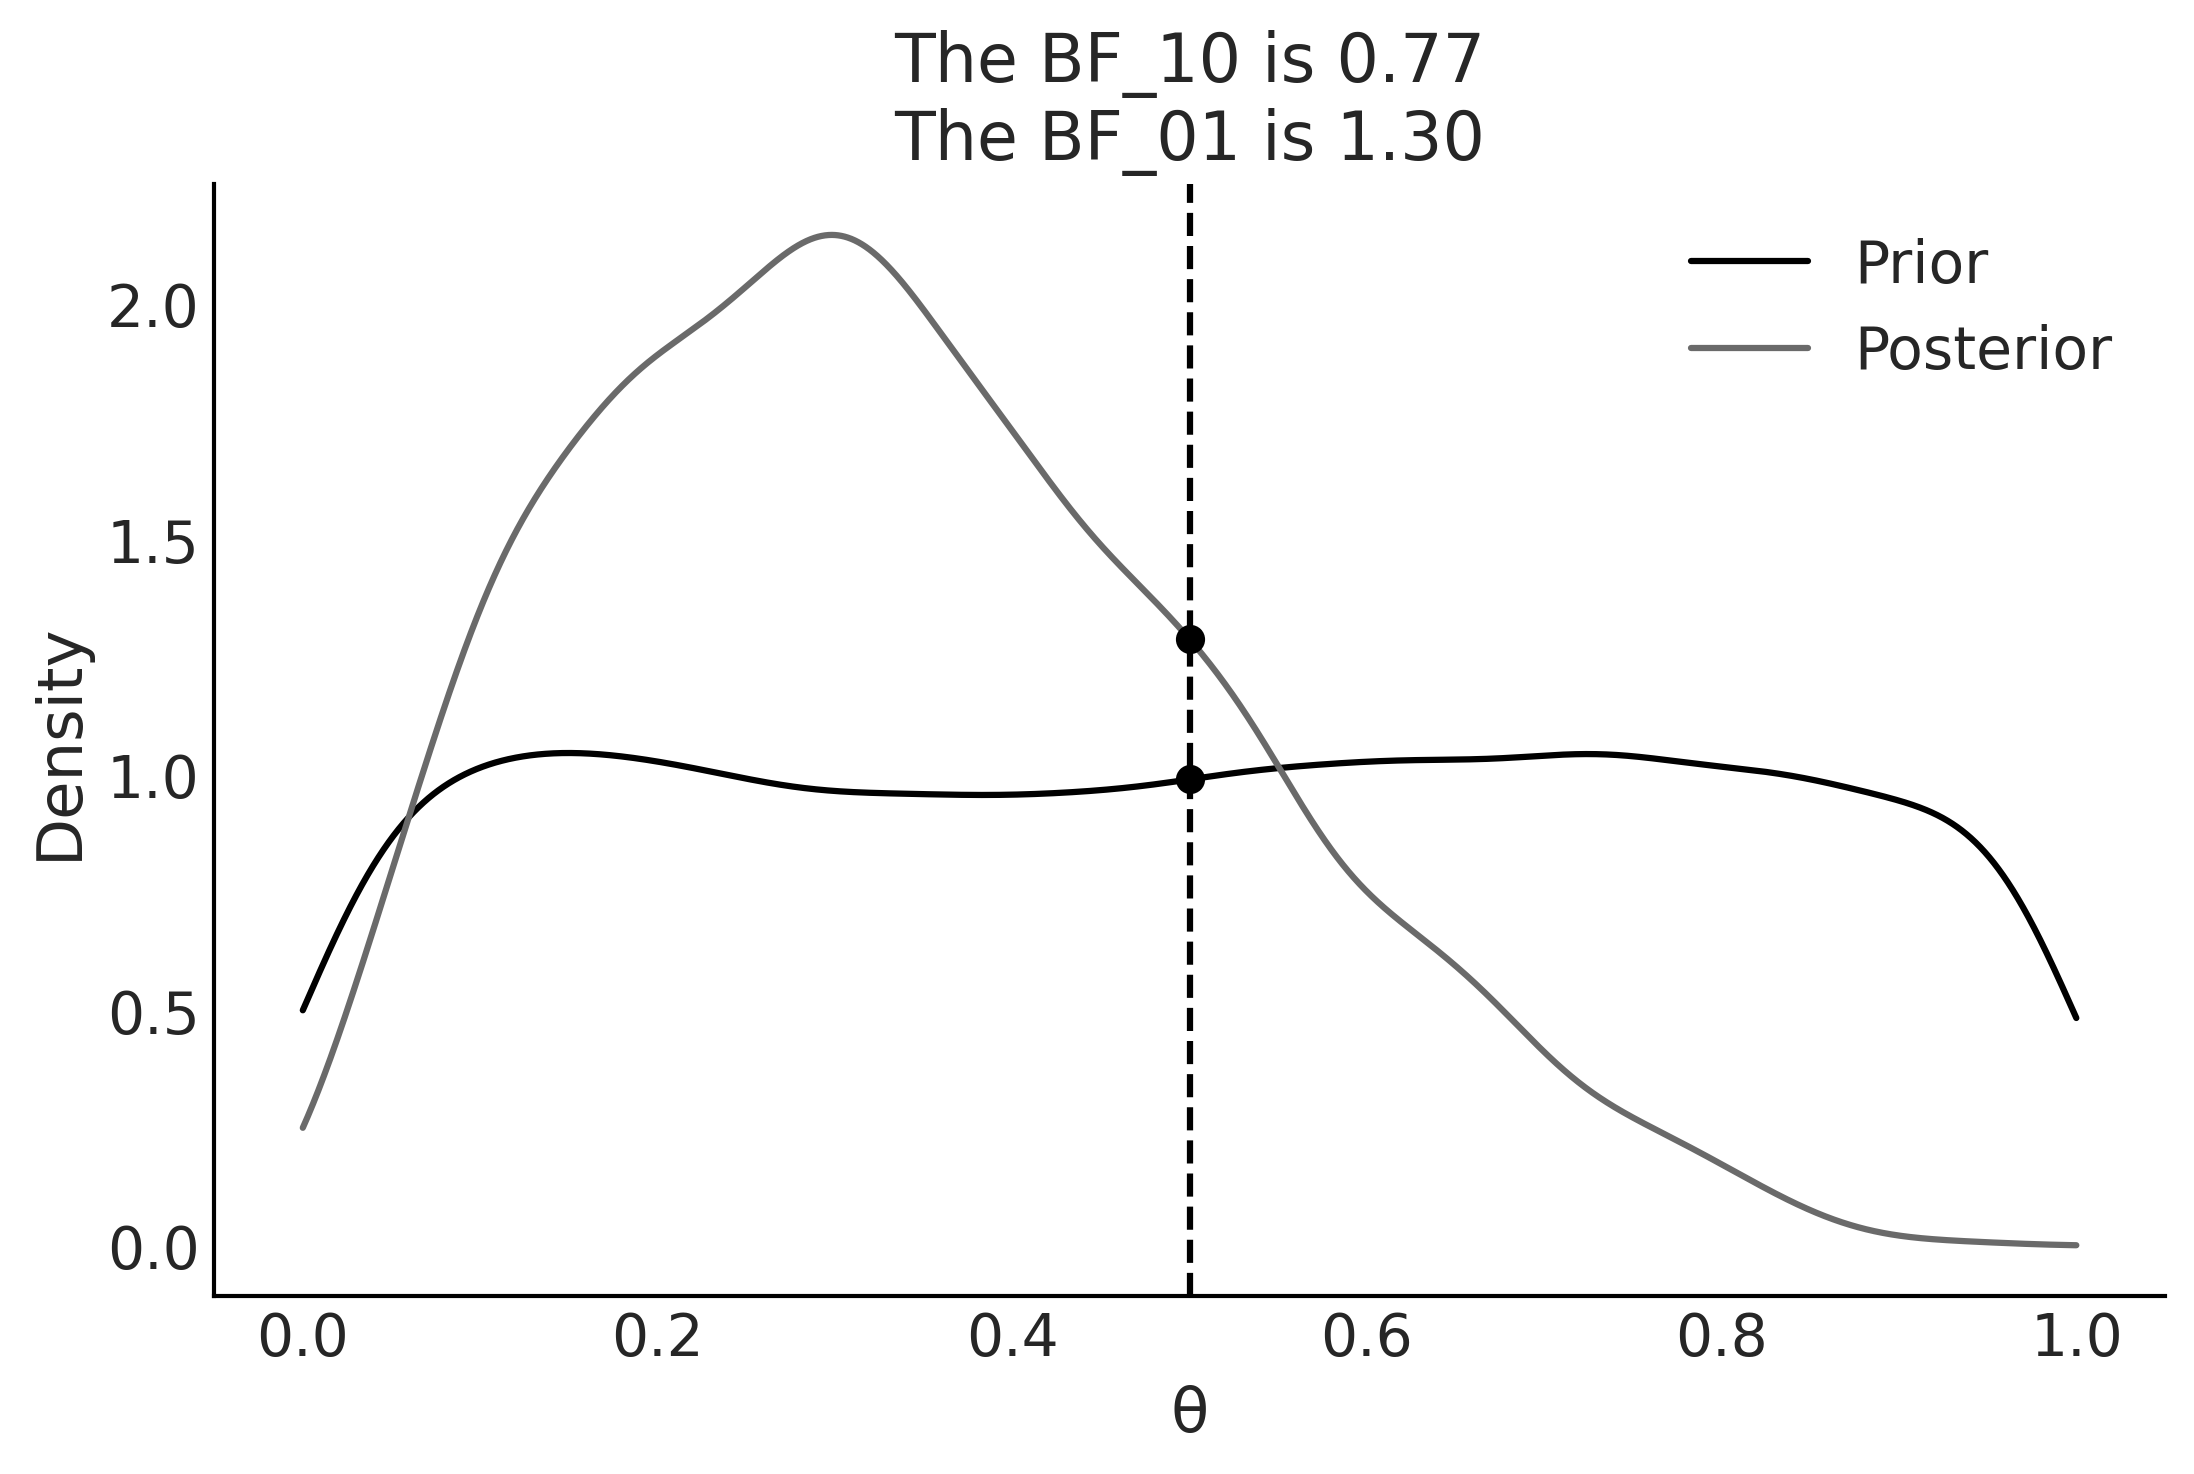

In [9]:
az.plot_bf(idata, var_name="θ", prior=np.random.uniform(0, 1, 10000), ref_val=0.5)
plt.savefig("../fig/idata_bf.png")

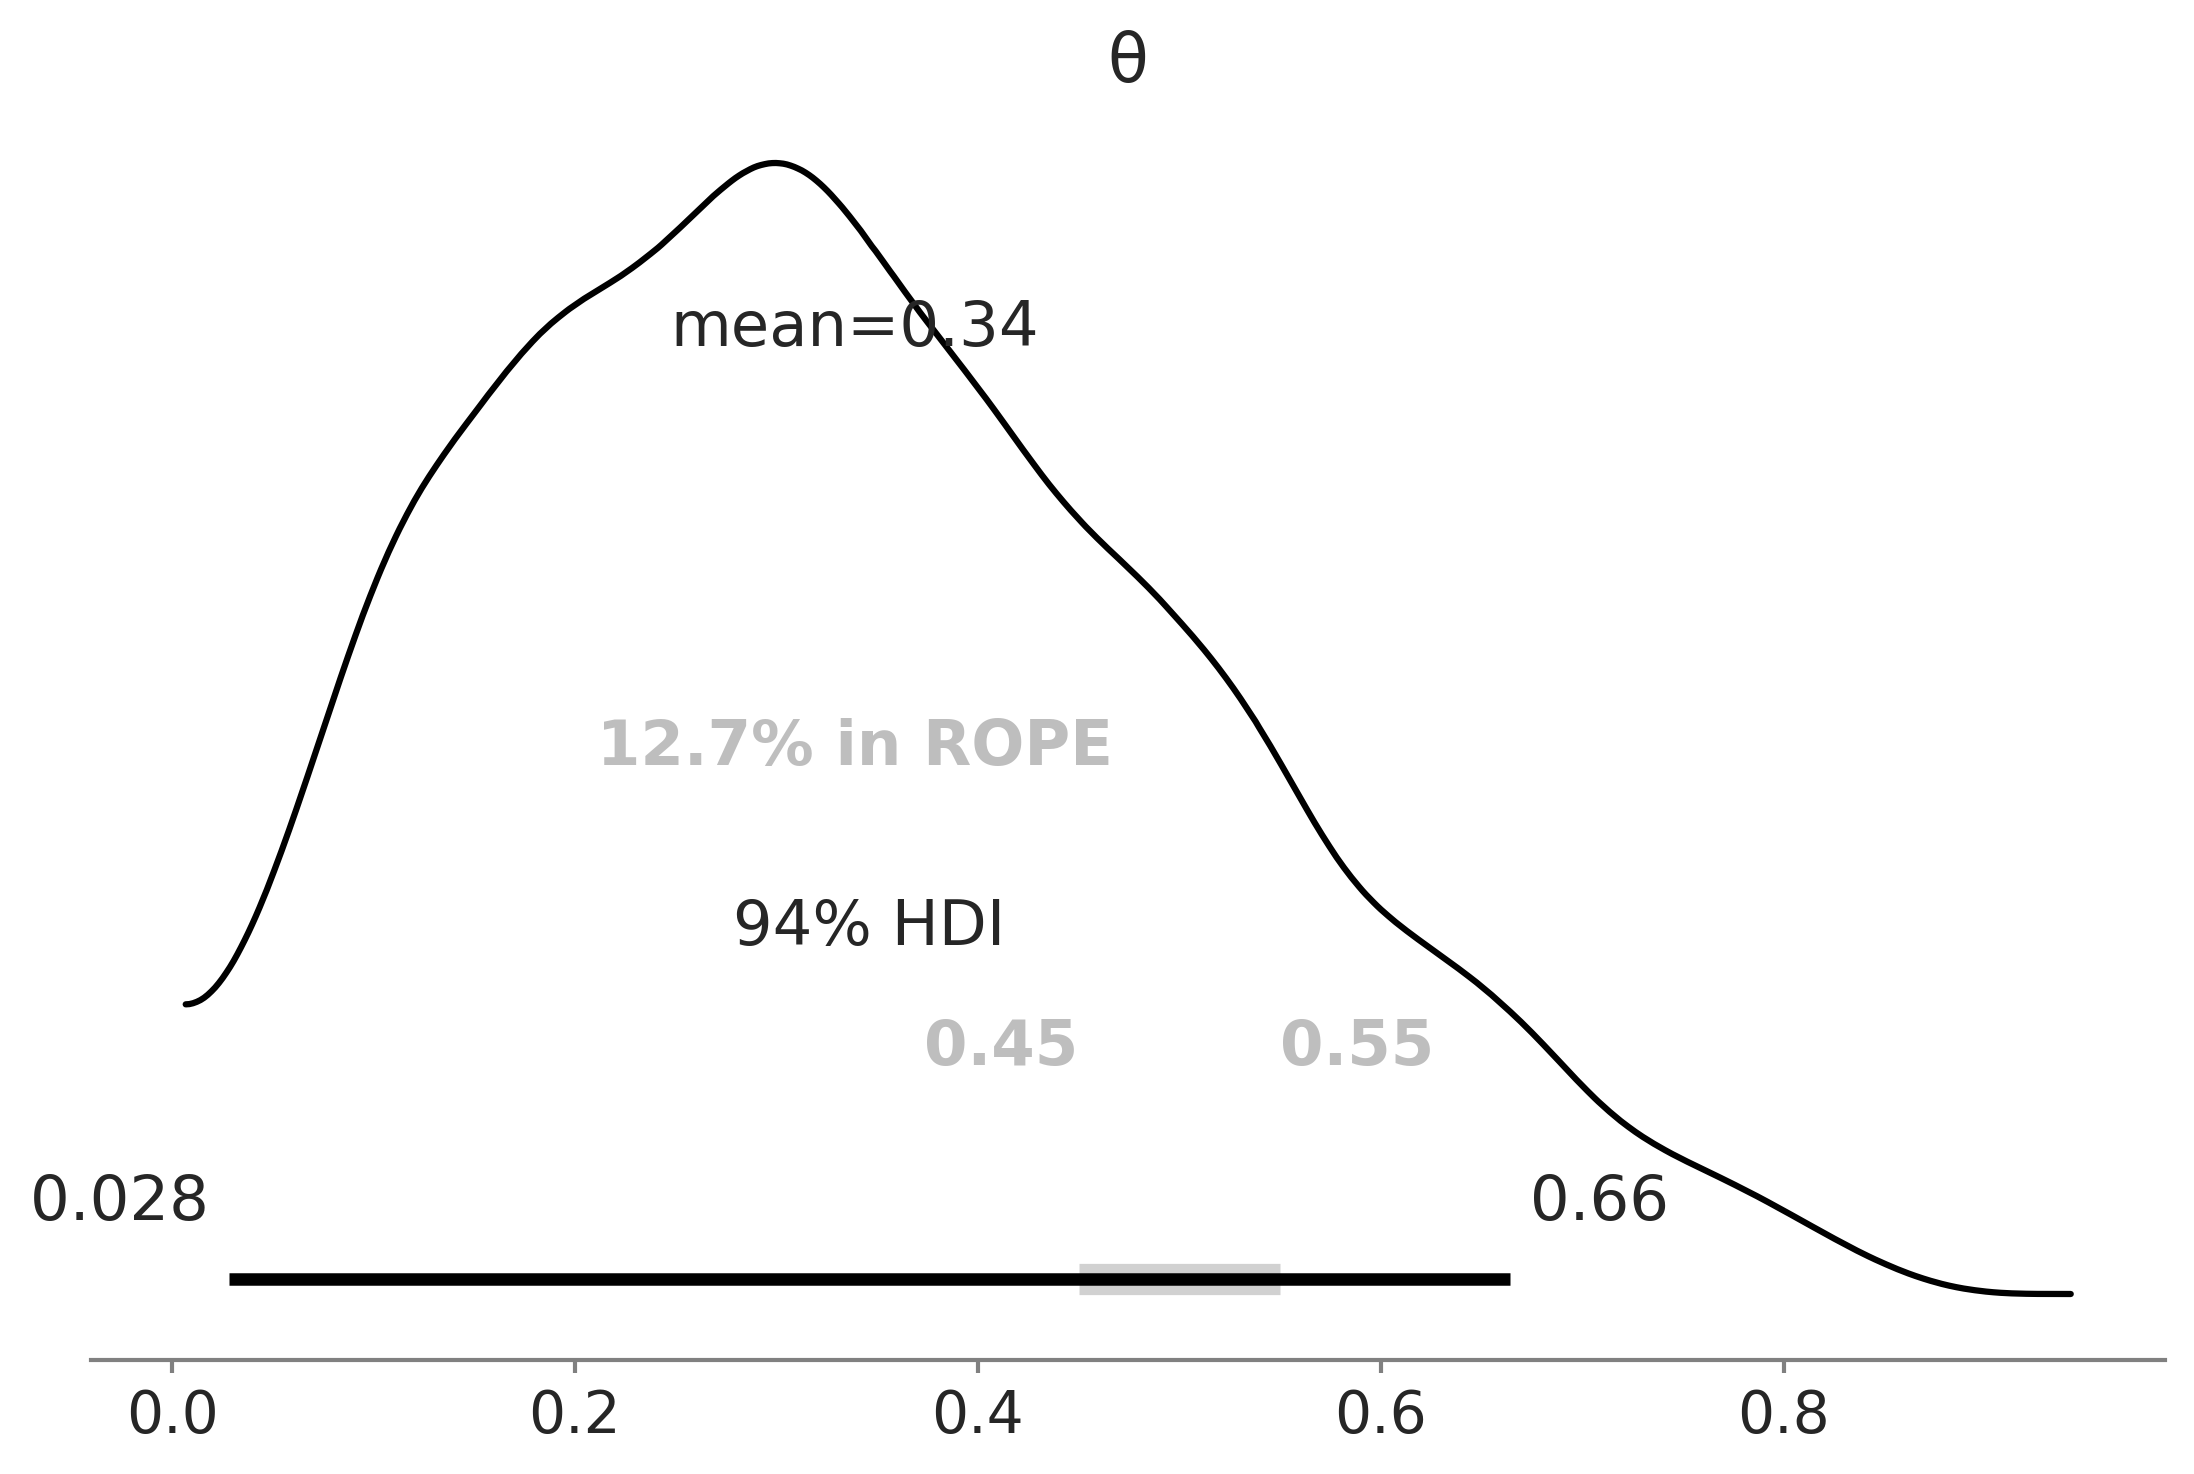

In [10]:
az.plot_posterior(idata, rope=[0.45, .55])
plt.savefig("../fig/idata_posterior_rope.png")


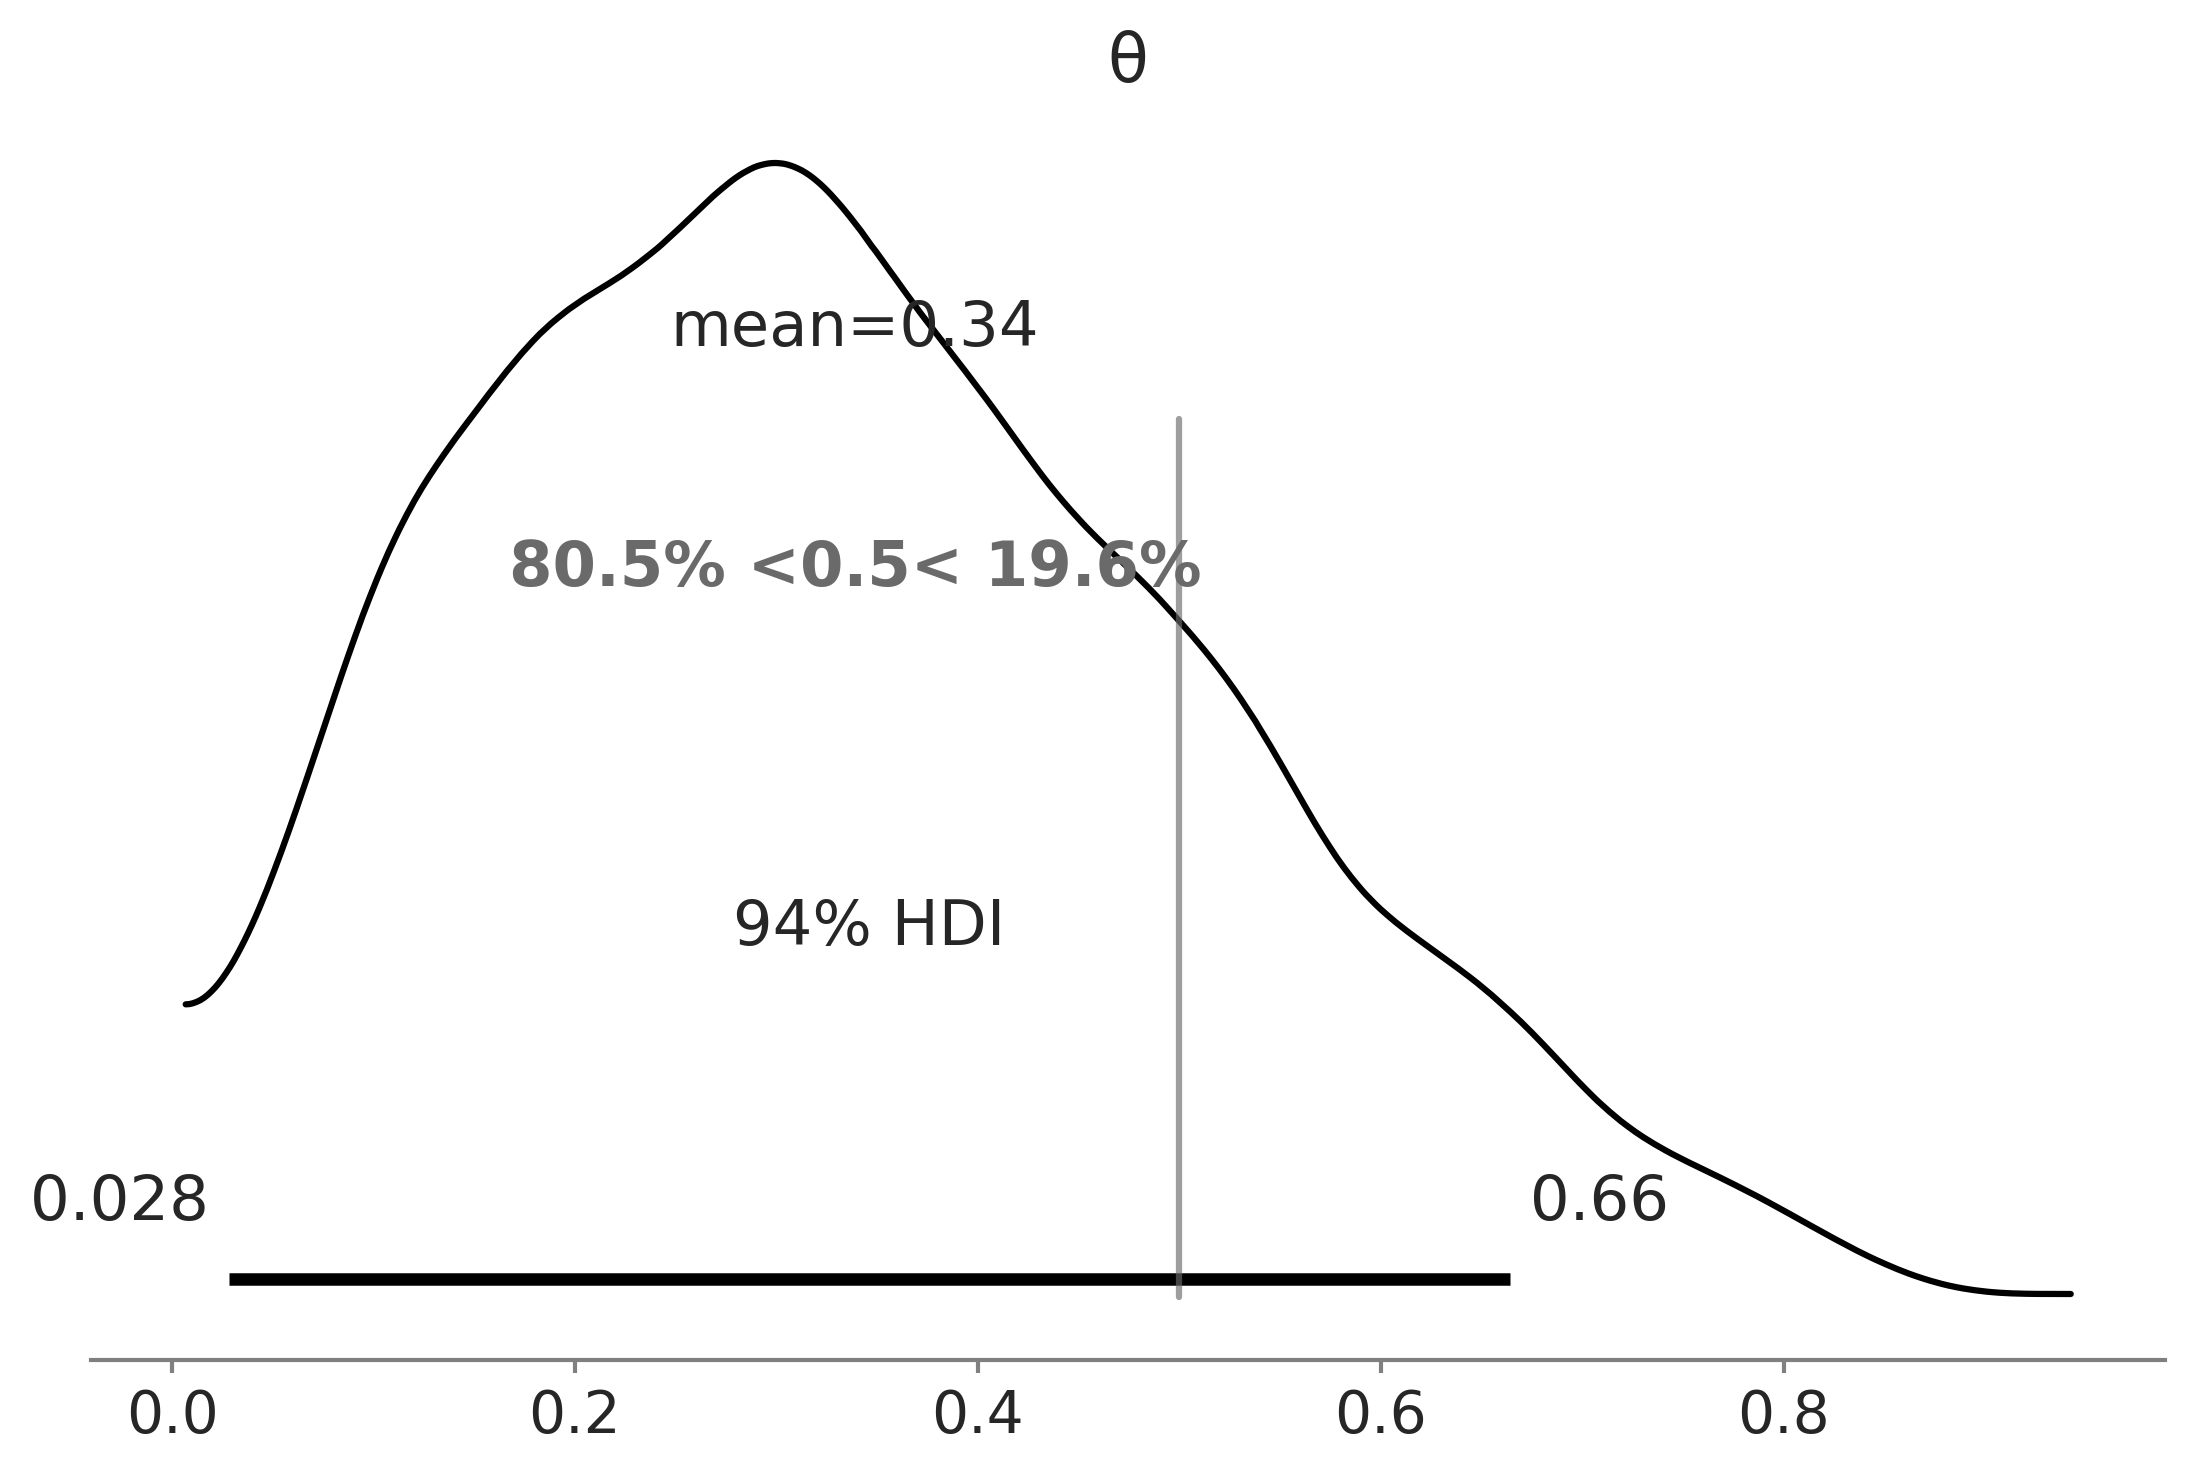

In [11]:
az.plot_posterior(idata, ref_val=0.5)
plt.savefig("../fig/idata_posterior_ref.png")

In [12]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
np.argmin(lossf_a)

64

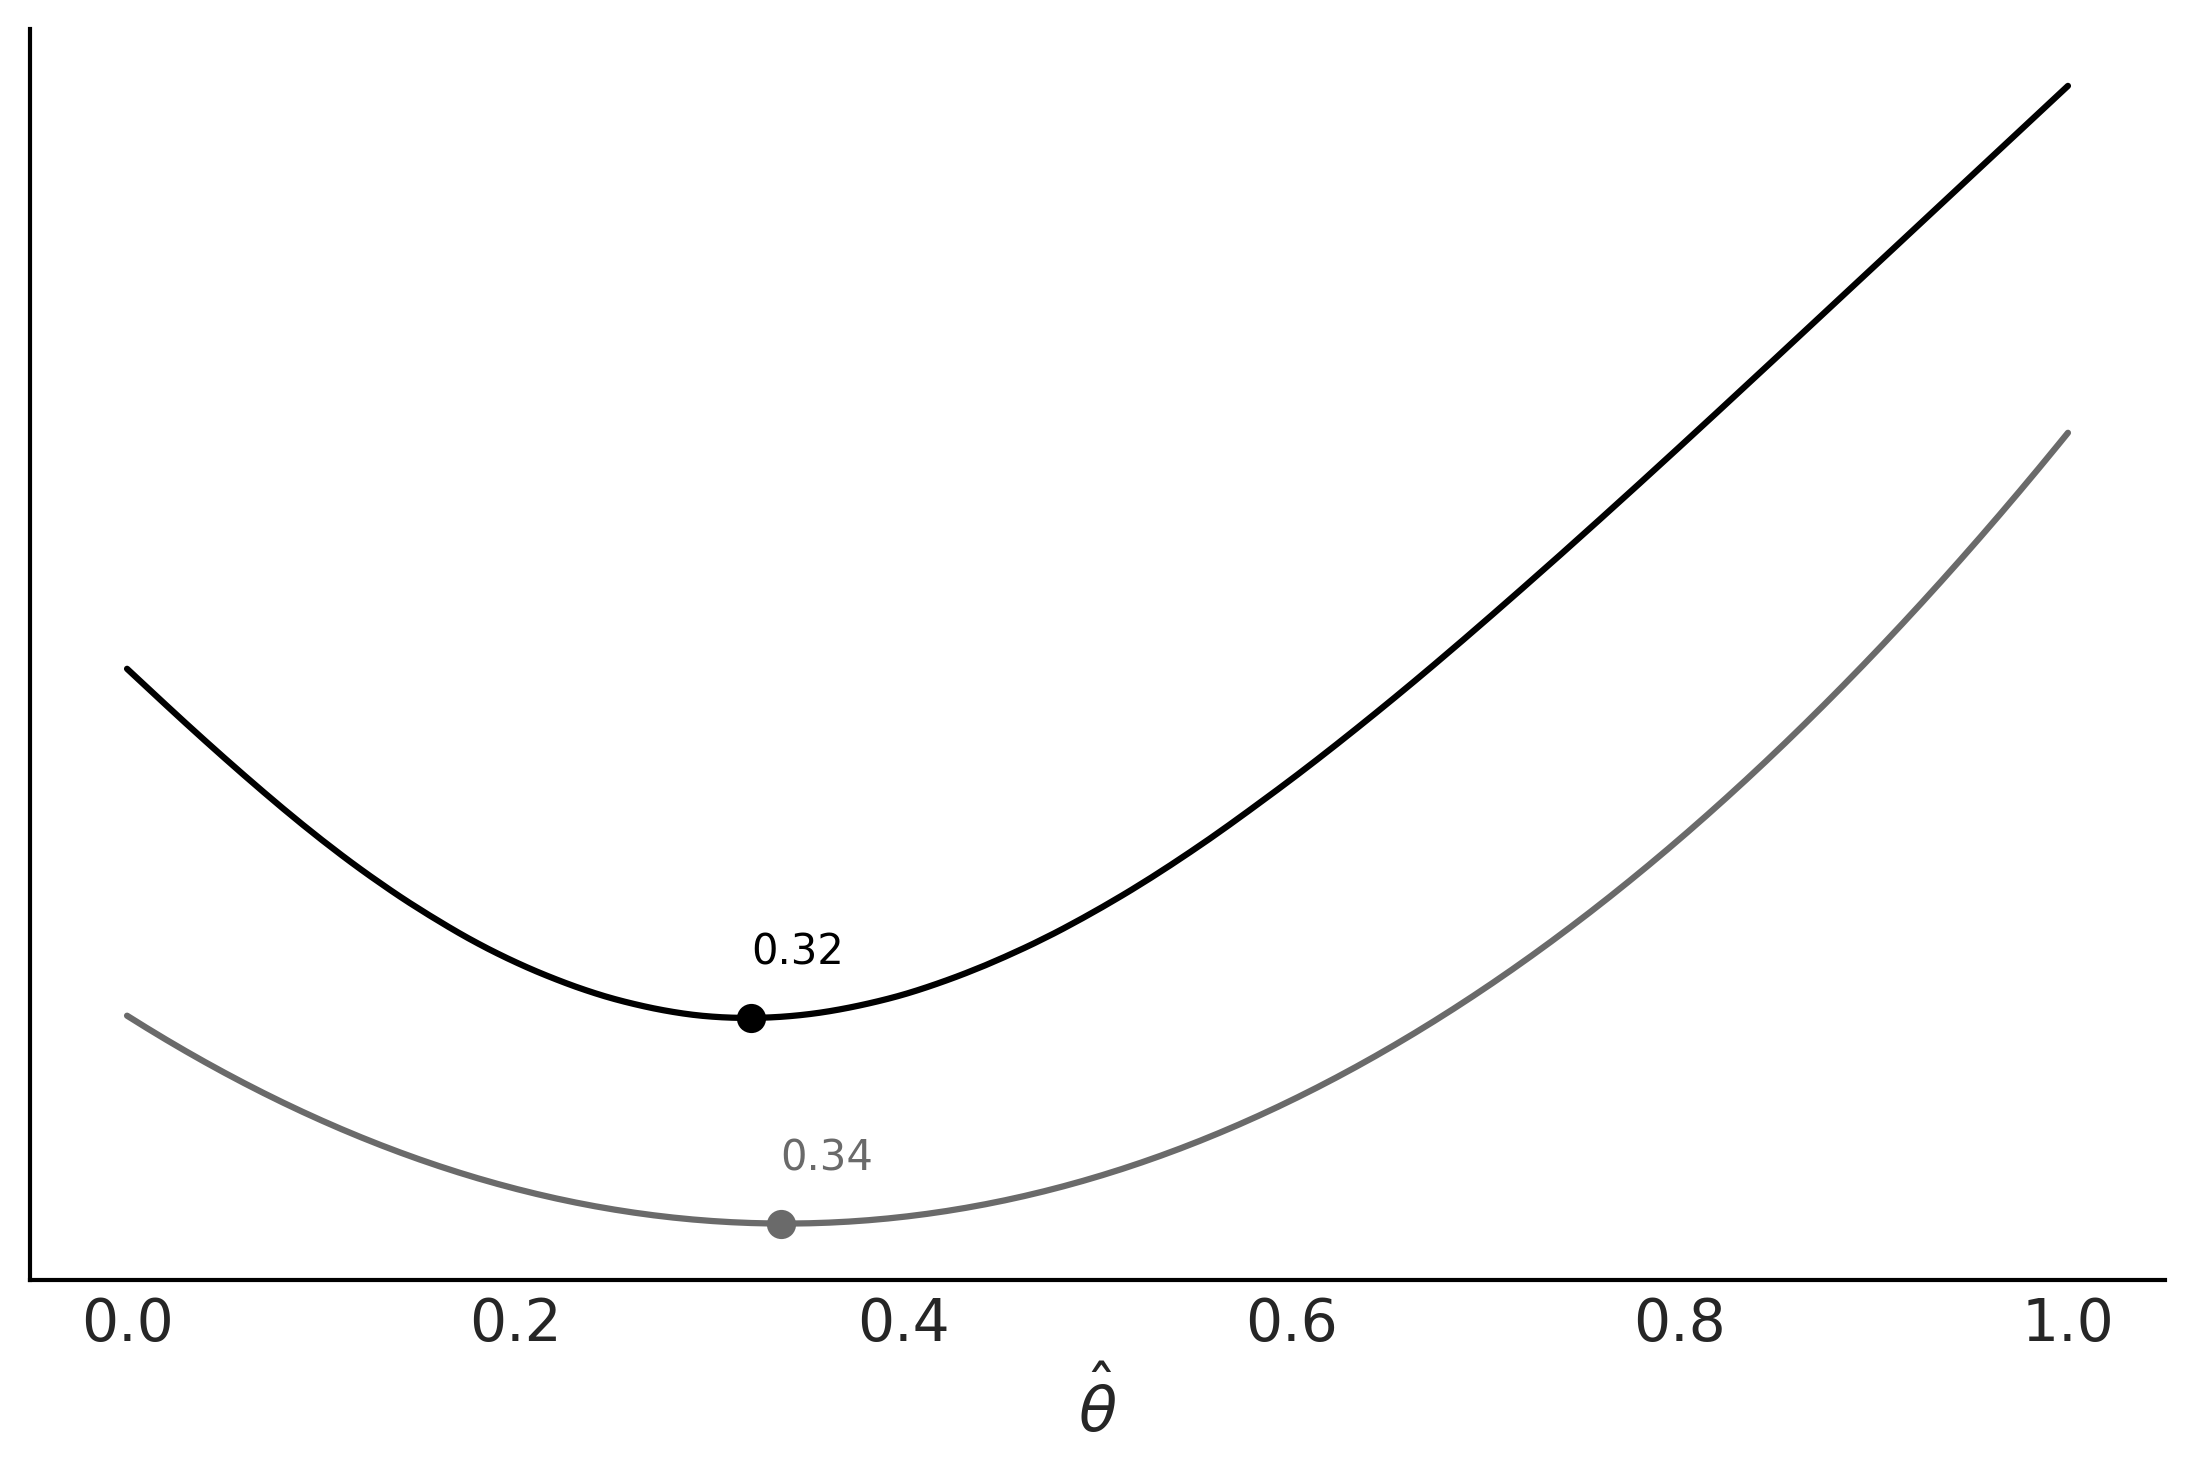

In [13]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

plt.savefig("../fig/idata_loss.png")

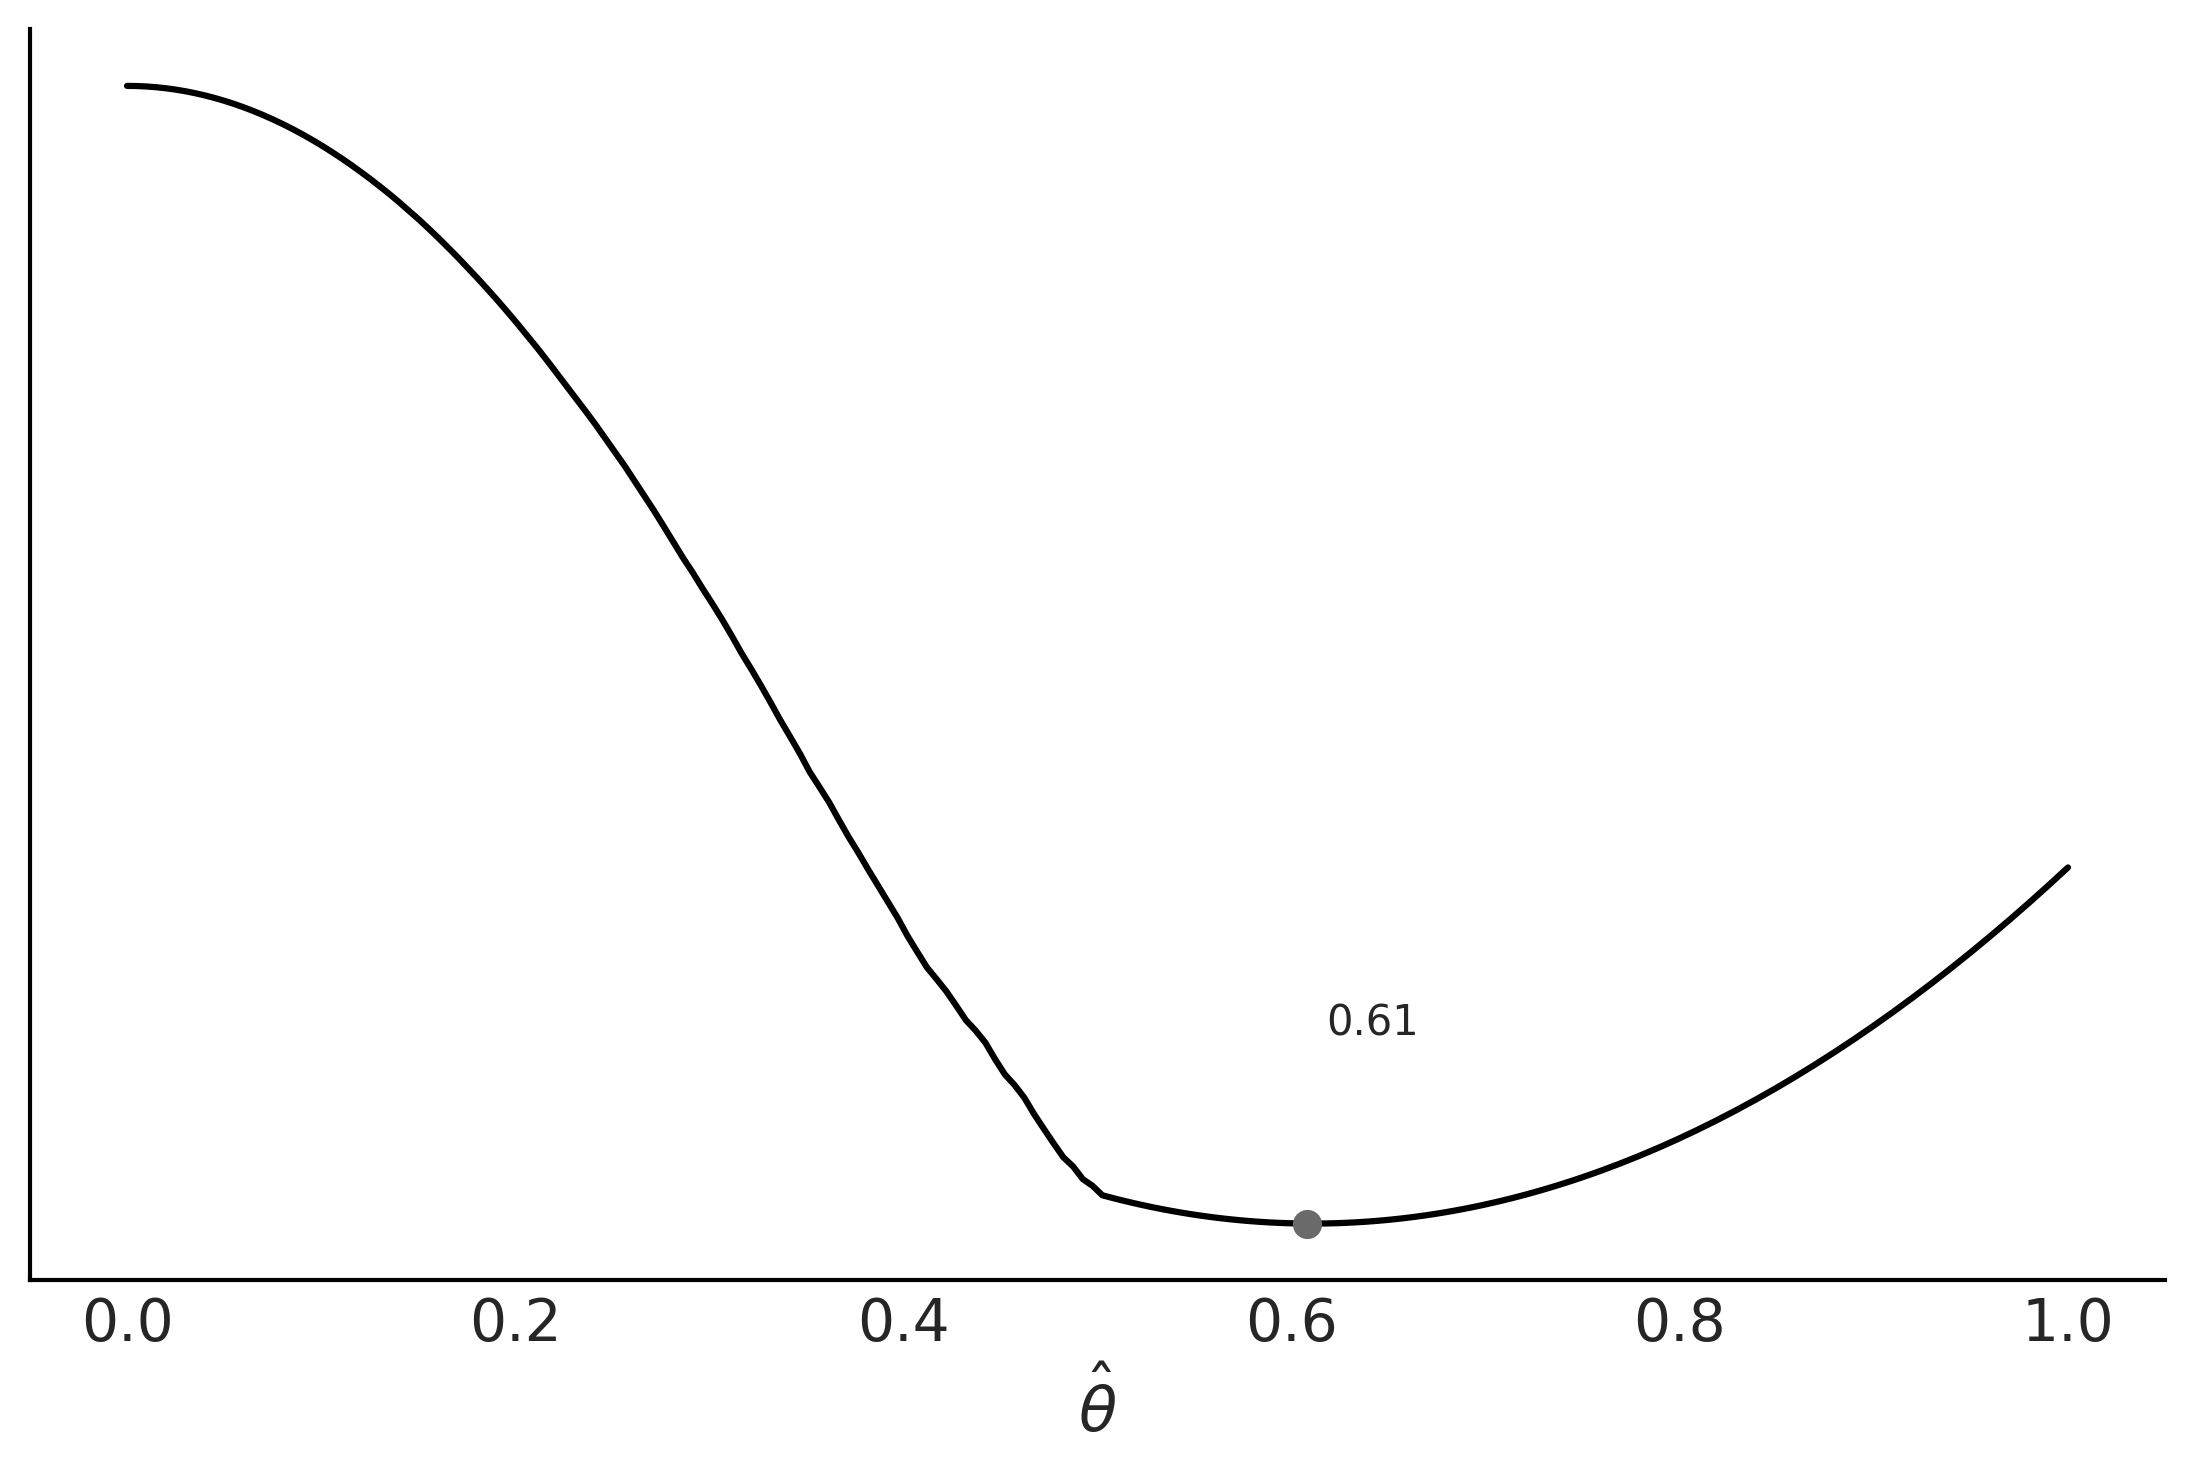

In [14]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)
mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

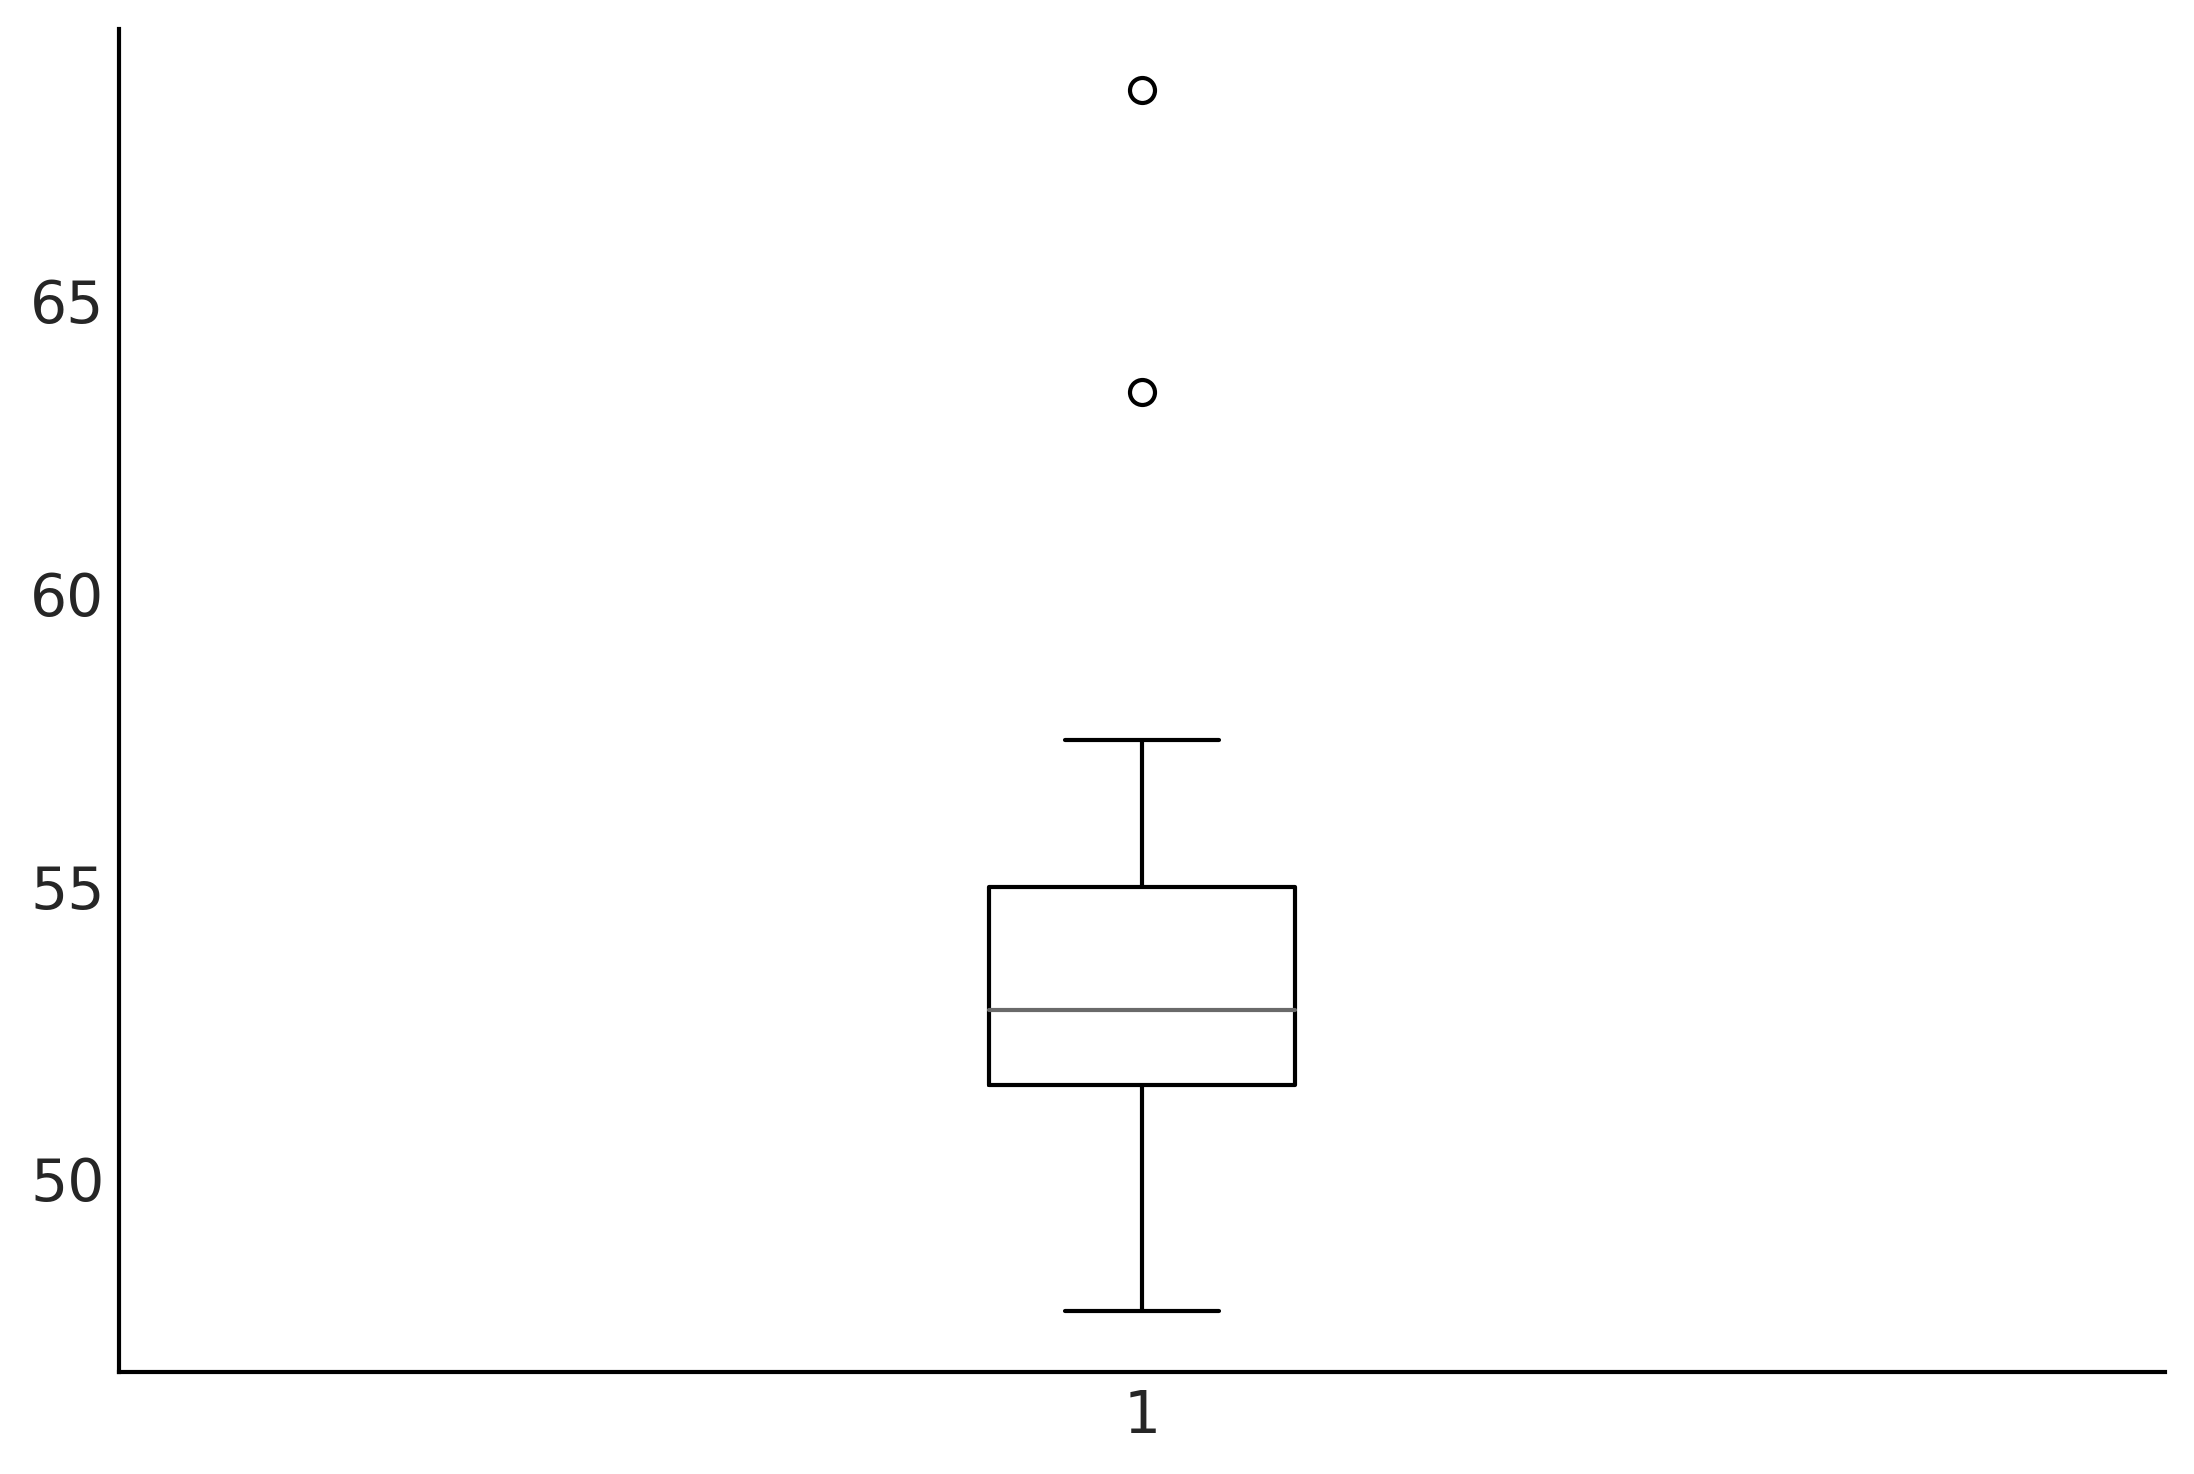

In [15]:
data = np.loadtxt('../data/chemical_shifts.csv')
plt.boxplot(data)
plt.savefig("../fig/boxplot.png")

In [16]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


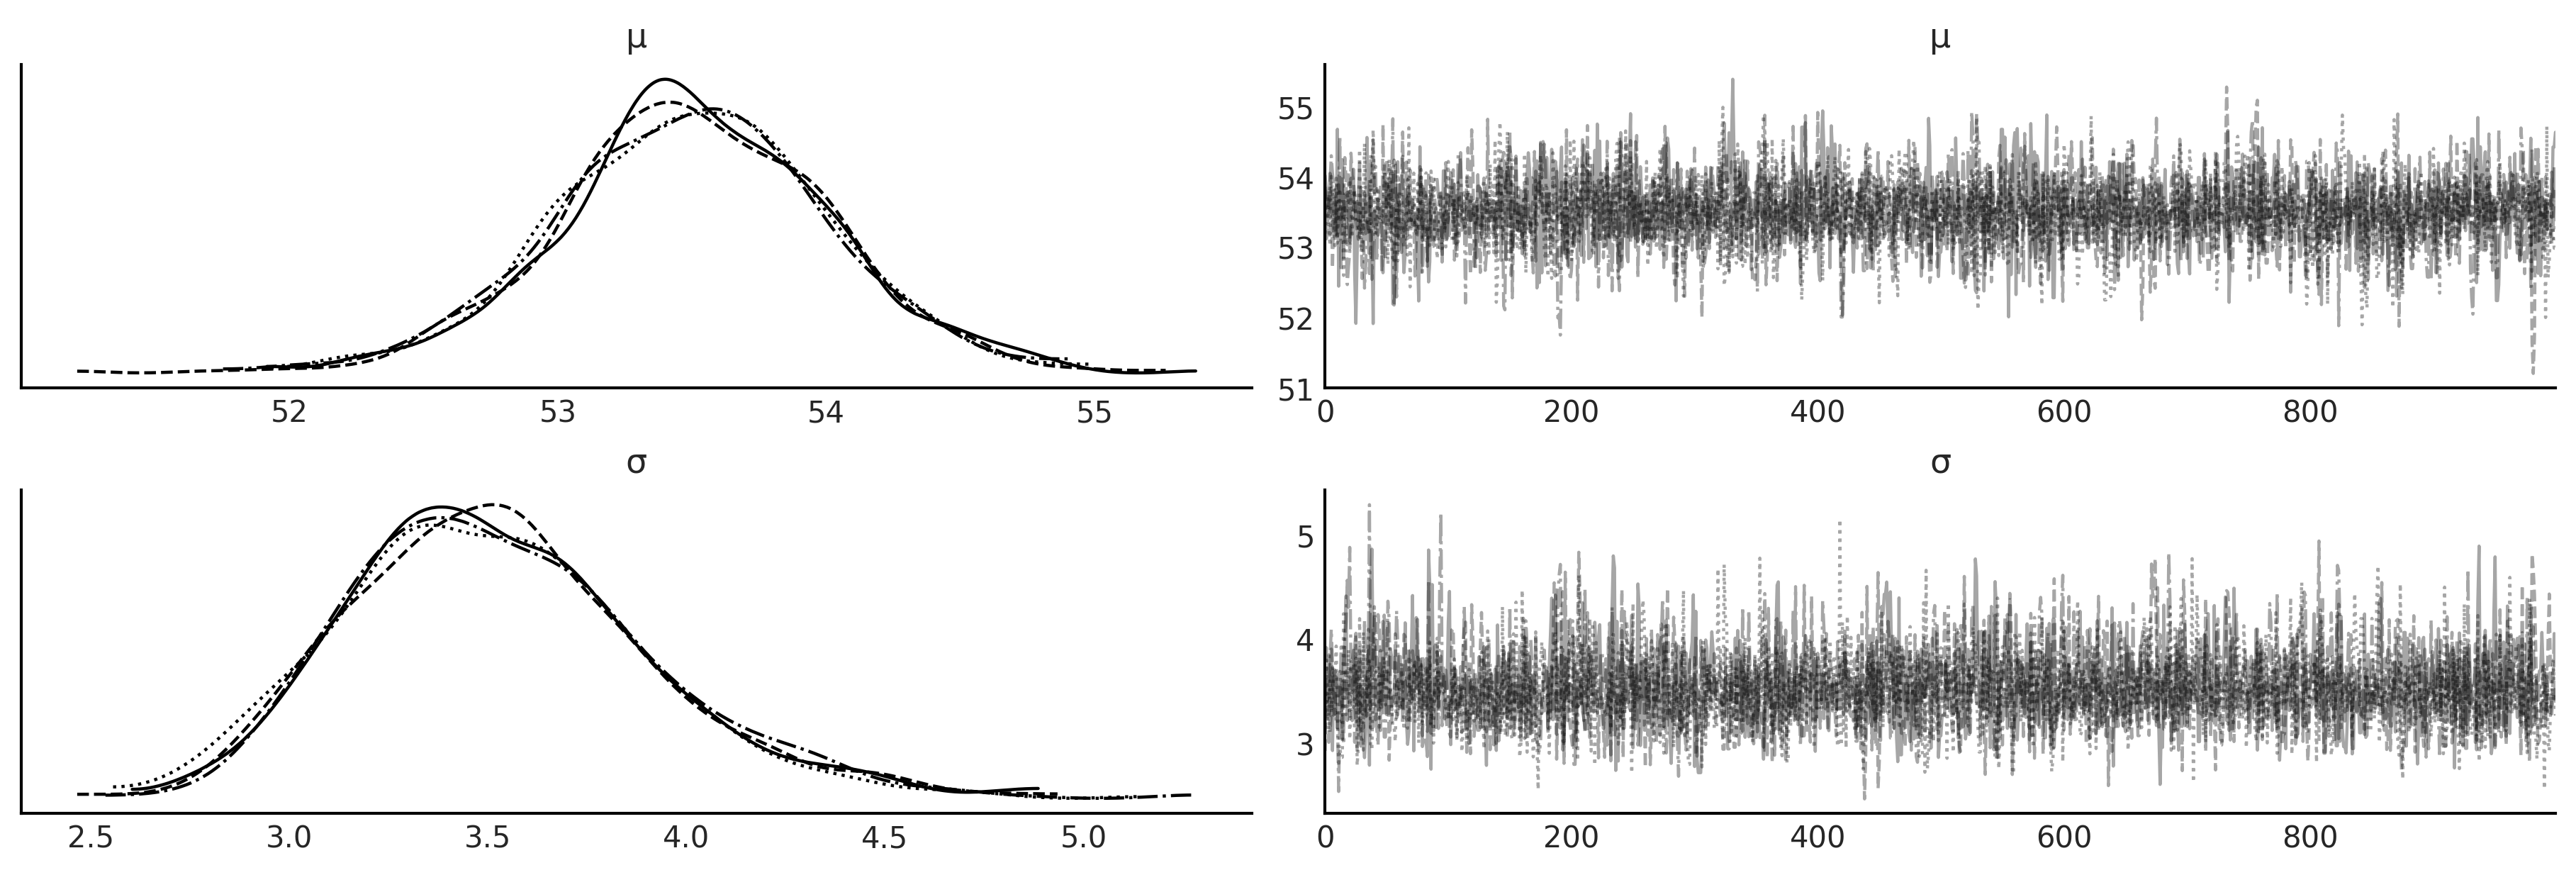

In [17]:
az.plot_trace(idata_g);
plt.savefig("../fig/idata_g.png")

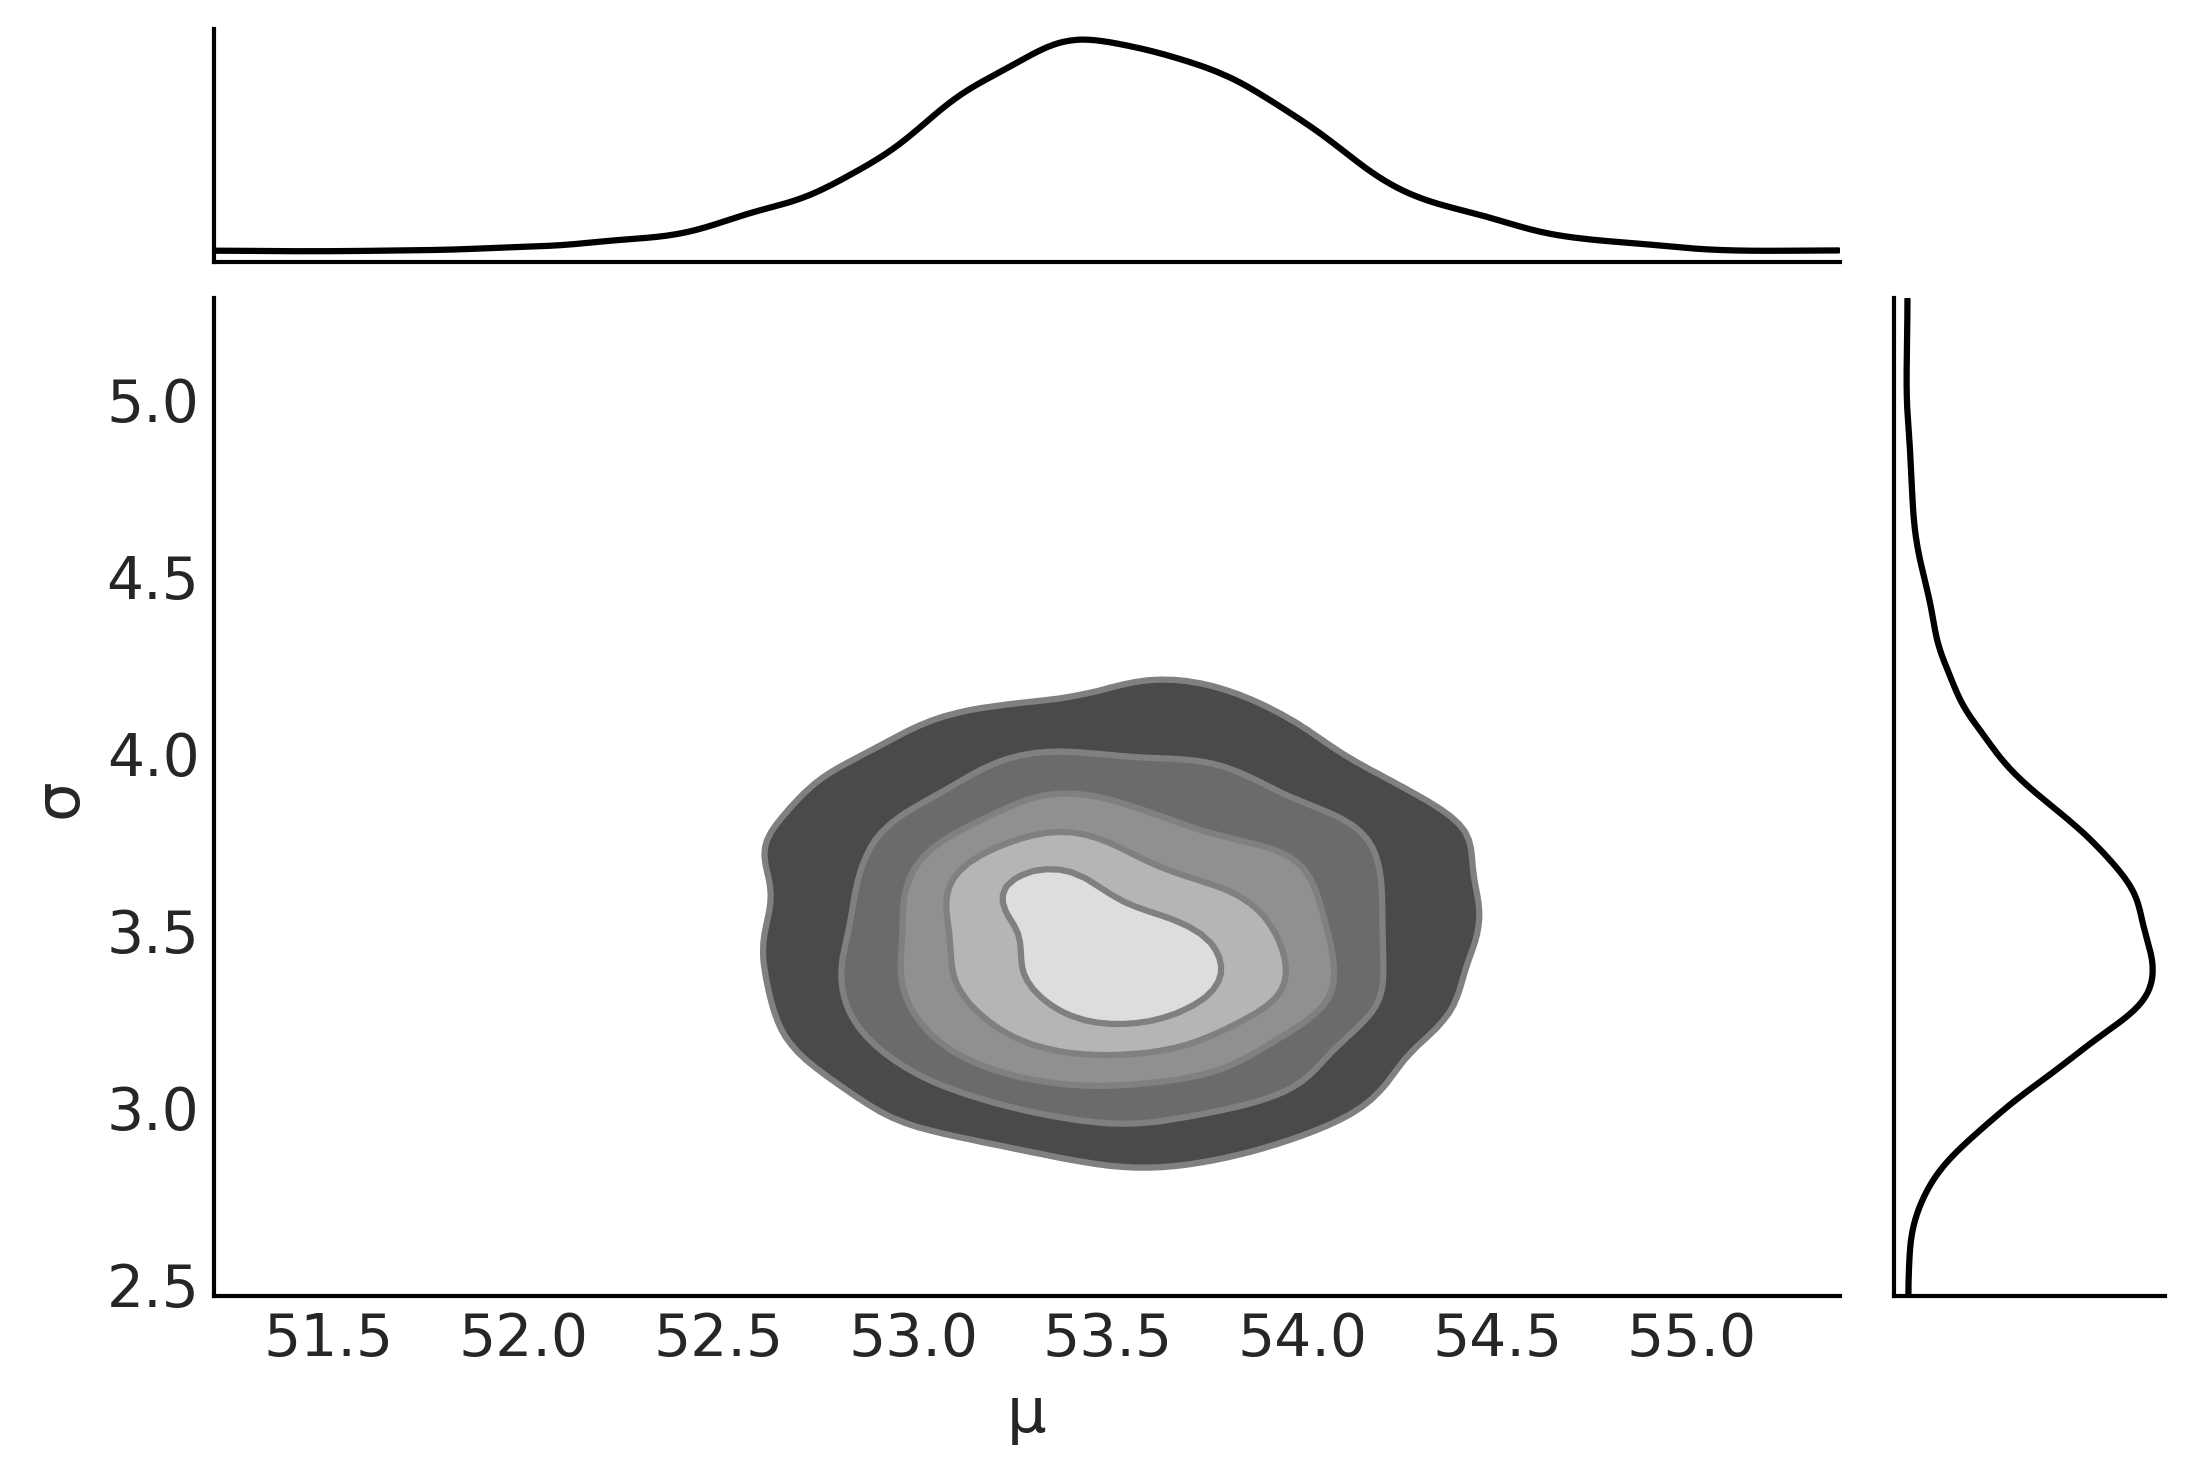

In [18]:
az.plot_pair(idata_g, kind='kde', marginals=True)
plt.savefig("../fig/idata_g_pair.png")

In [19]:
az.summary(idata_g, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
μ  53.50  0.50   52.52    54.43
σ   3.52  0.38    2.86     4.25

In [20]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True, random_seed=4591)


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

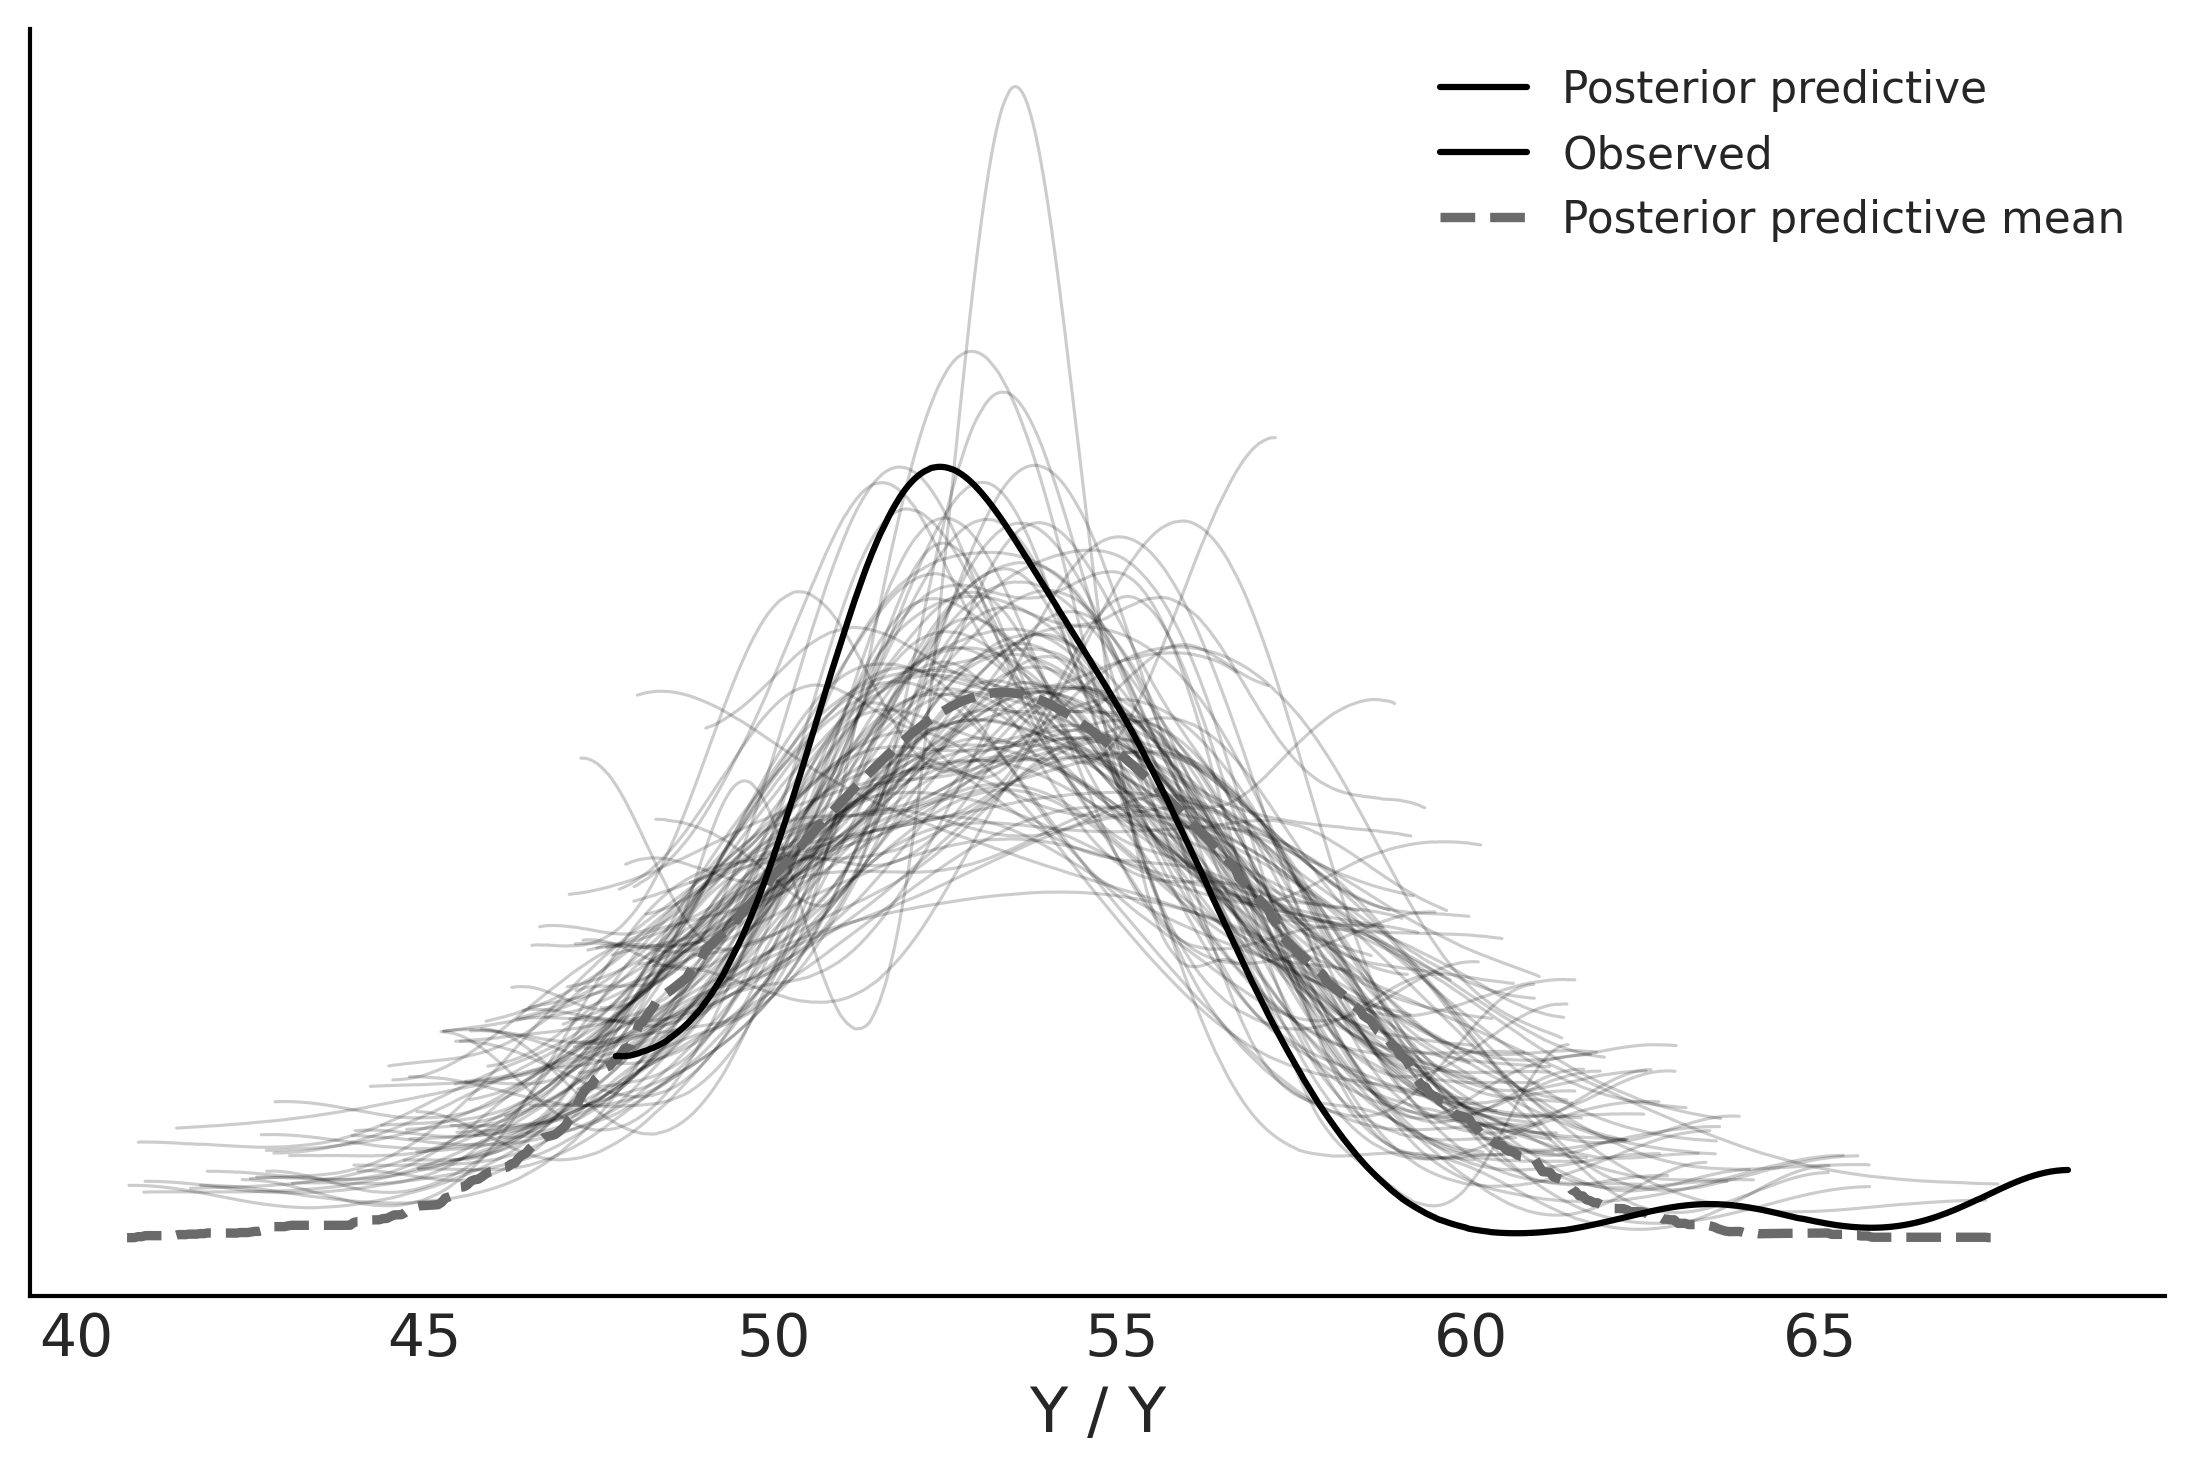

In [21]:
az.plot_ppc(idata_g, num_pp_samples=100)
plt.savefig("../fig/idata_g_ppc.png")

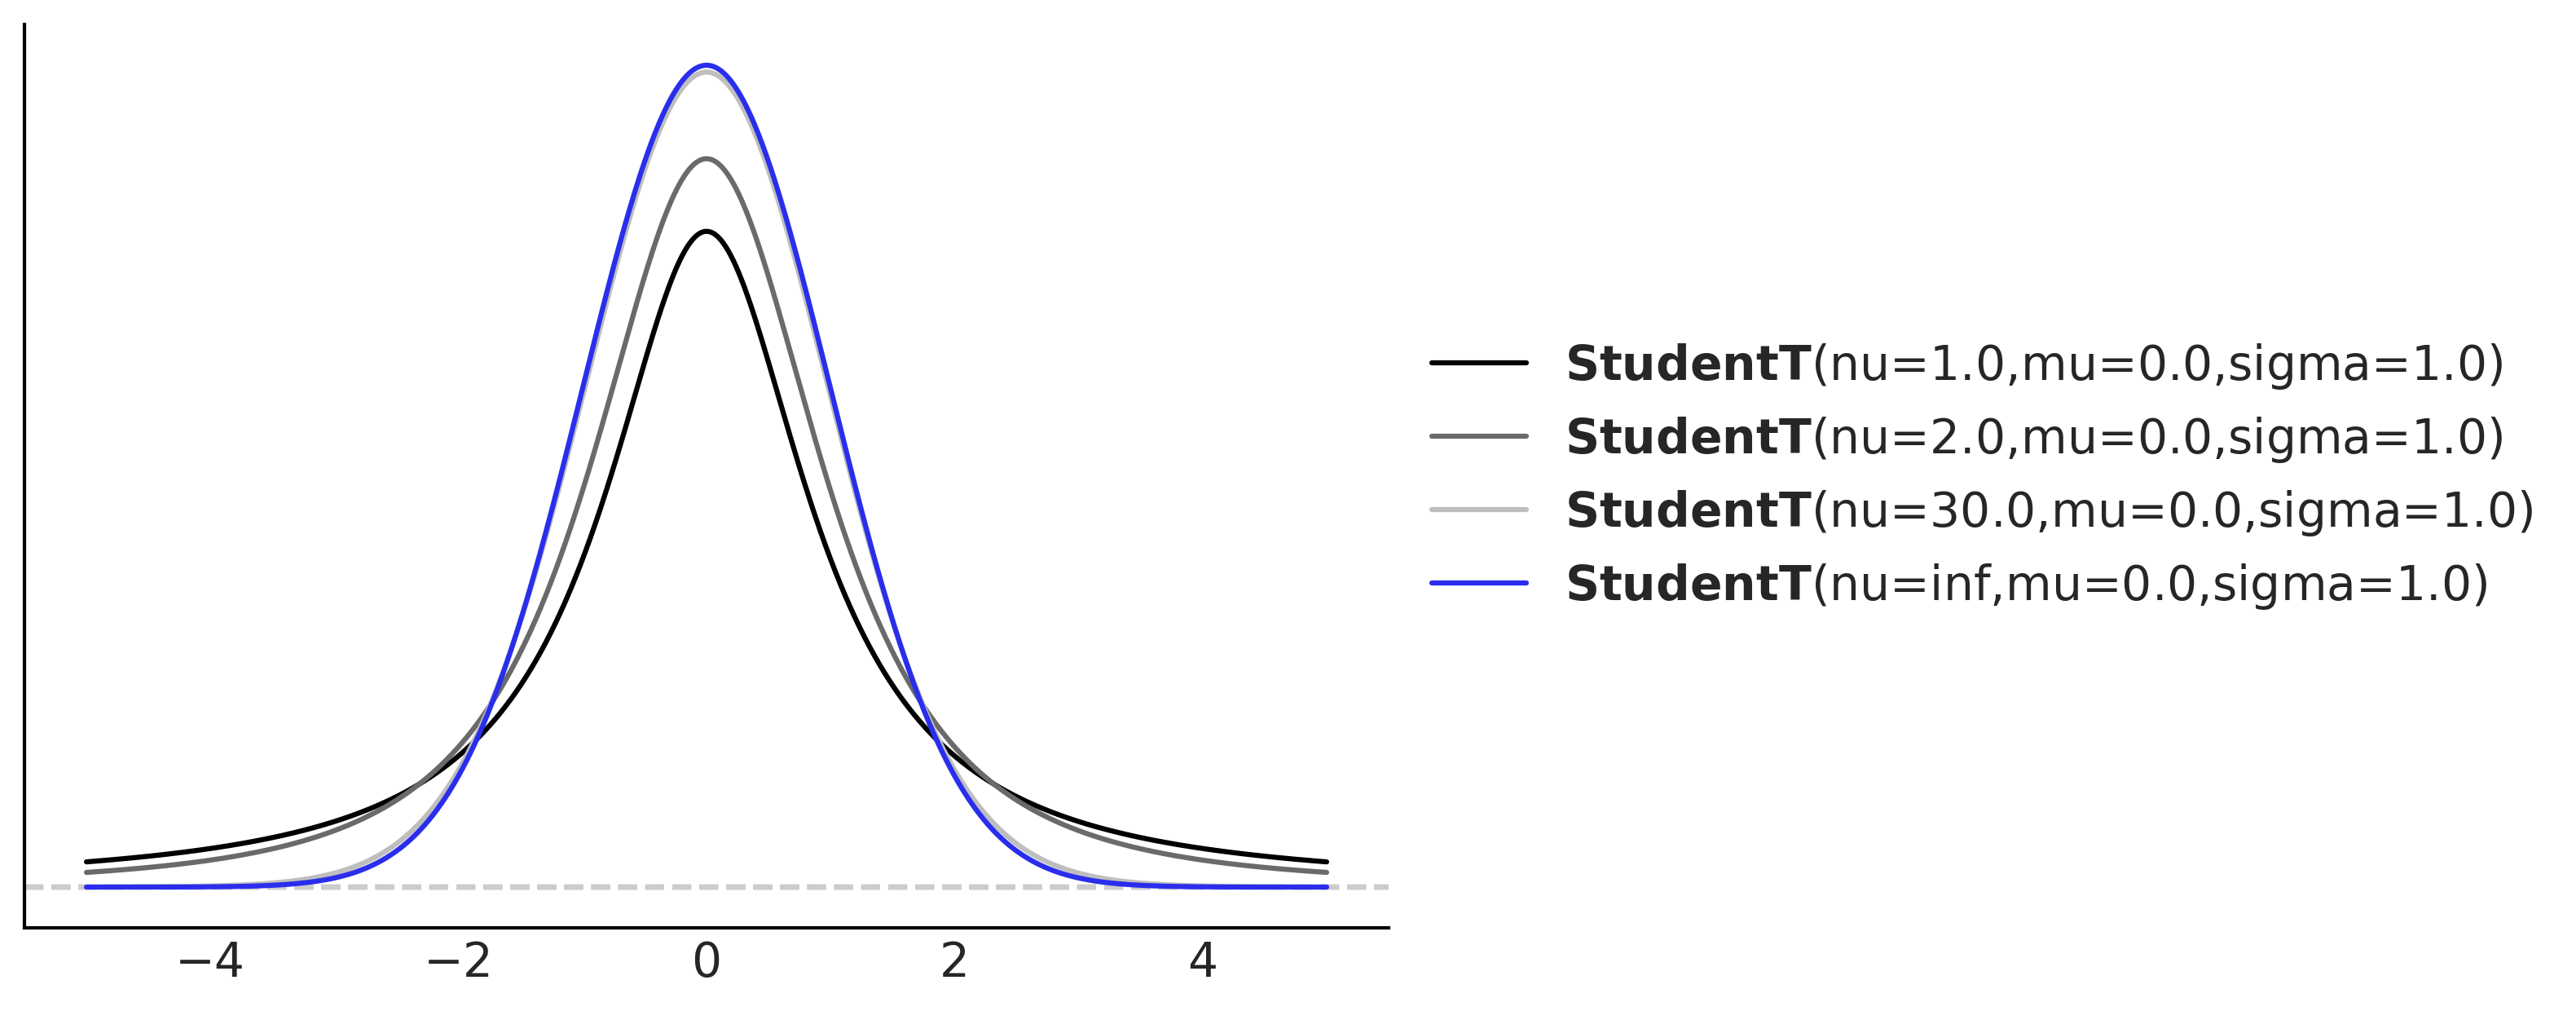

In [22]:
pz.StudentT(1, 0, 1).plot_pdf(support=(-5, 5))
pz.StudentT(2, 0, 1).plot_pdf(support=(-5, 5))
pz.StudentT(30, 0, 1).plot_pdf(support=(-5, 5))
pz.StudentT(np.inf, 0, 1).plot_pdf(support=(-5, 5))
plt.savefig("../fig/student_t.png")

In [23]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=data)
    idata_t = pm.sample(random_seed=4591)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


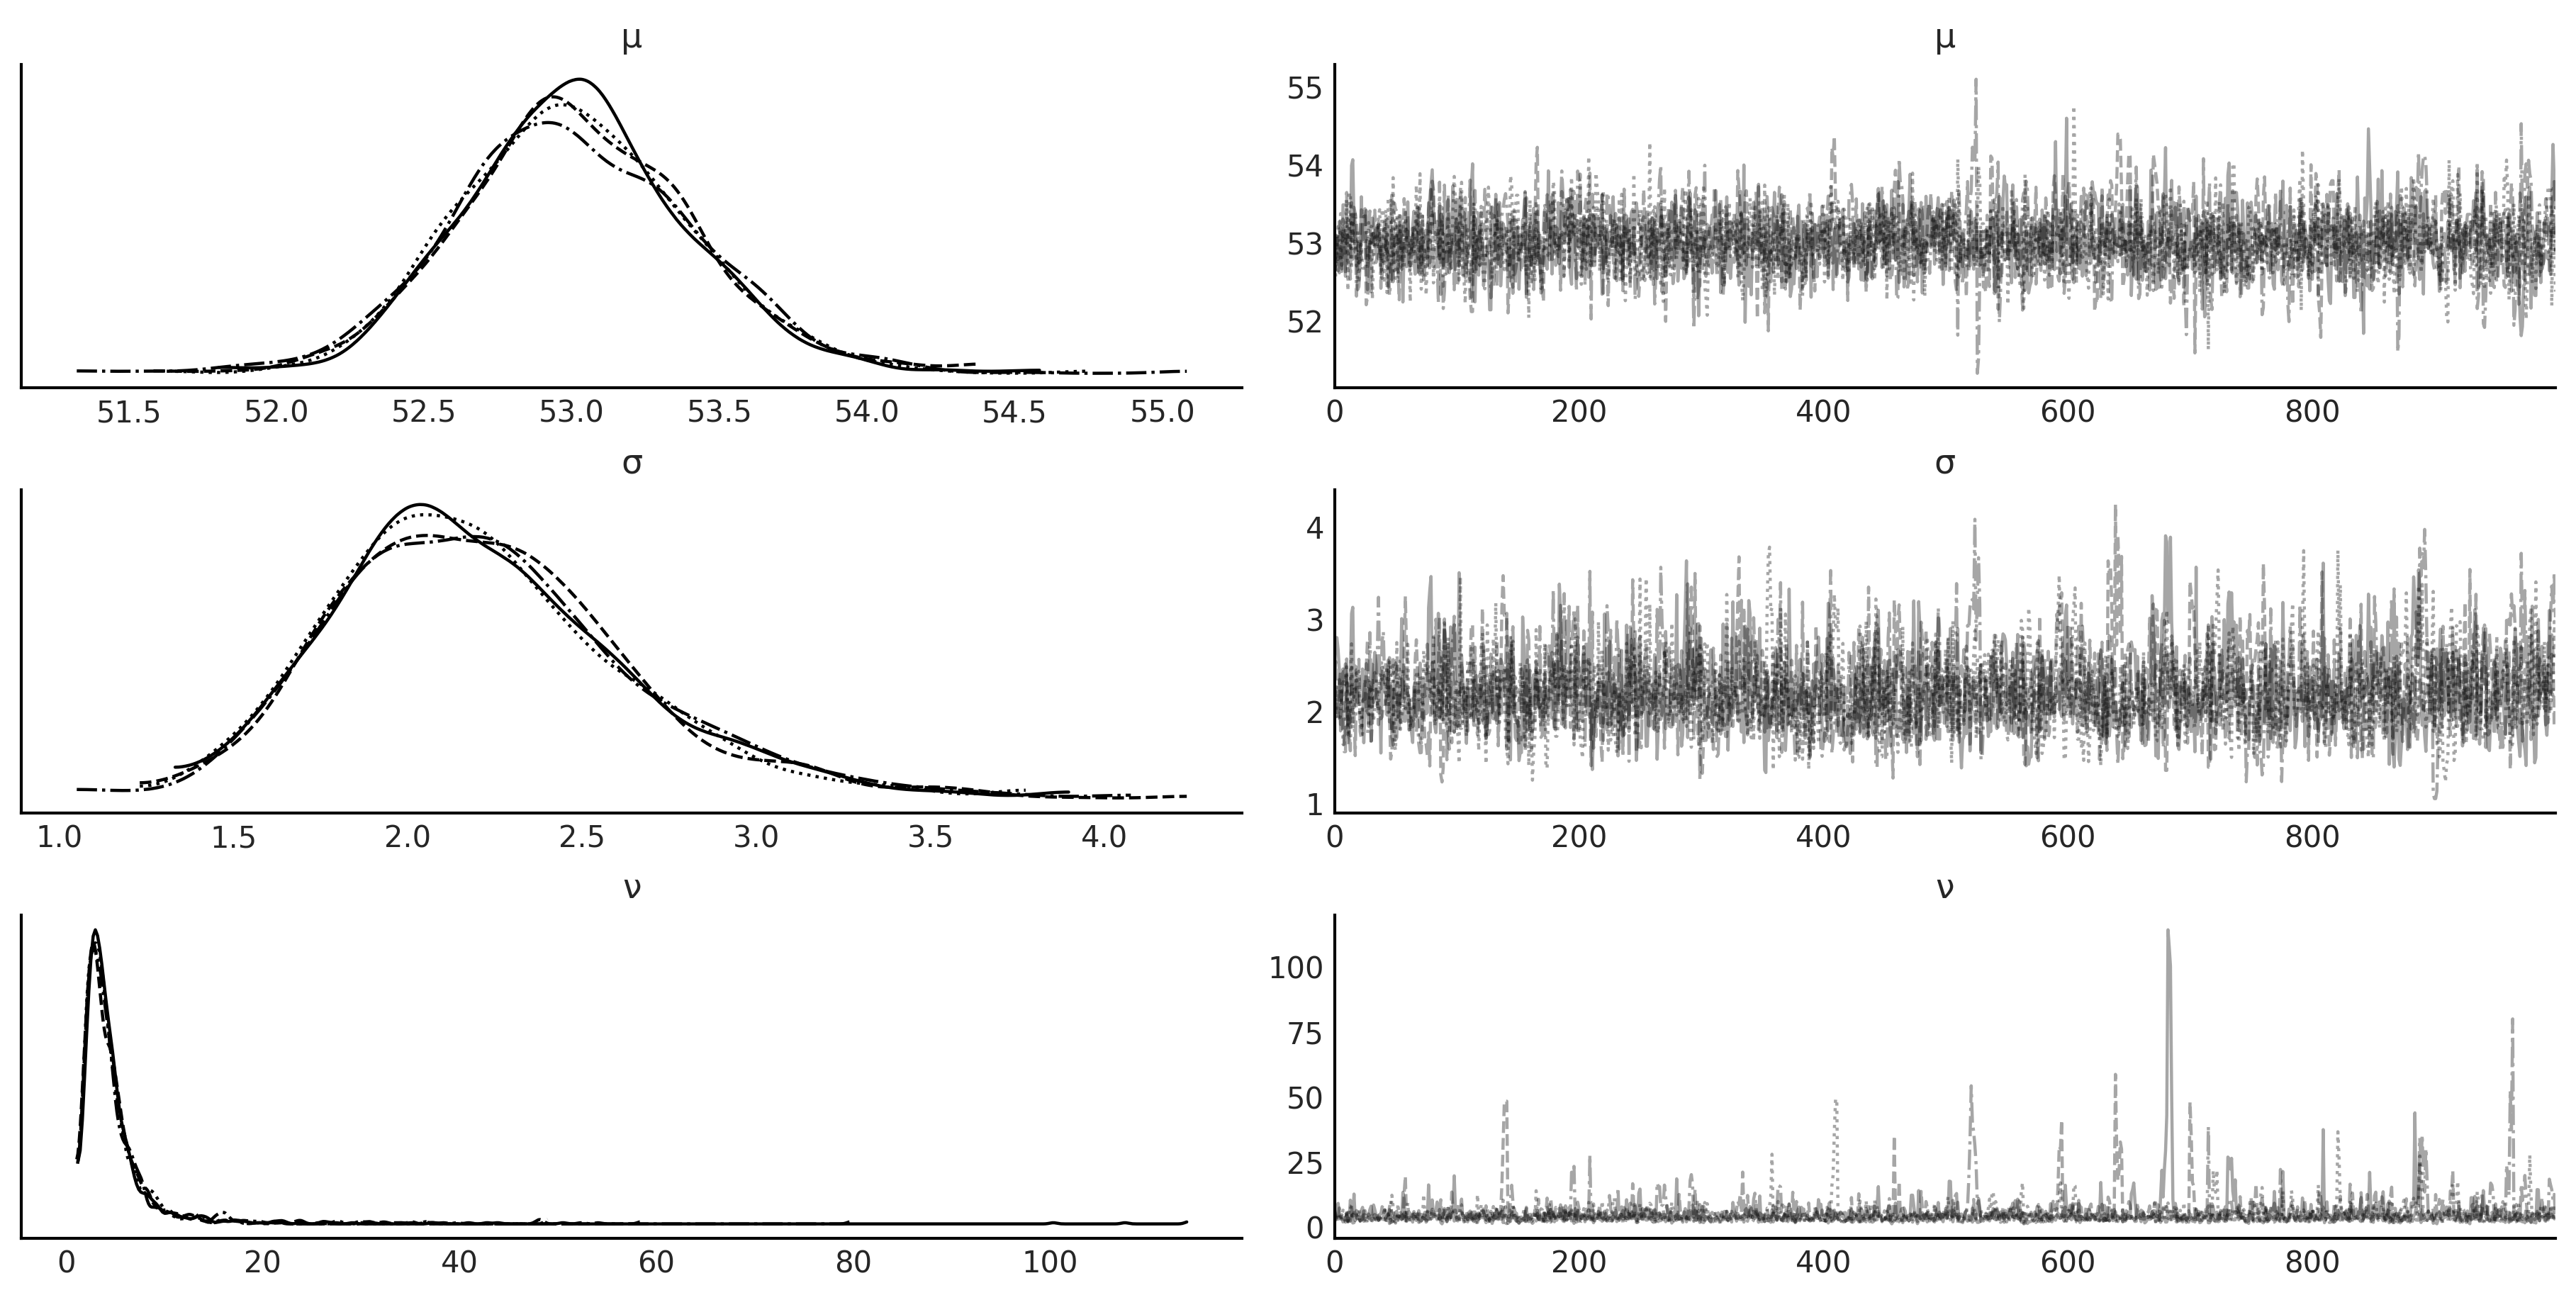

In [24]:
az.plot_trace(idata_t)
plt.savefig("../fig/idata_t_trace.png")

In [25]:
az.summary(idata_t, kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
μ  53.01  0.39   52.27    53.71
σ   2.21  0.42    1.46     3.01
ν   4.94  5.45    1.07    10.10

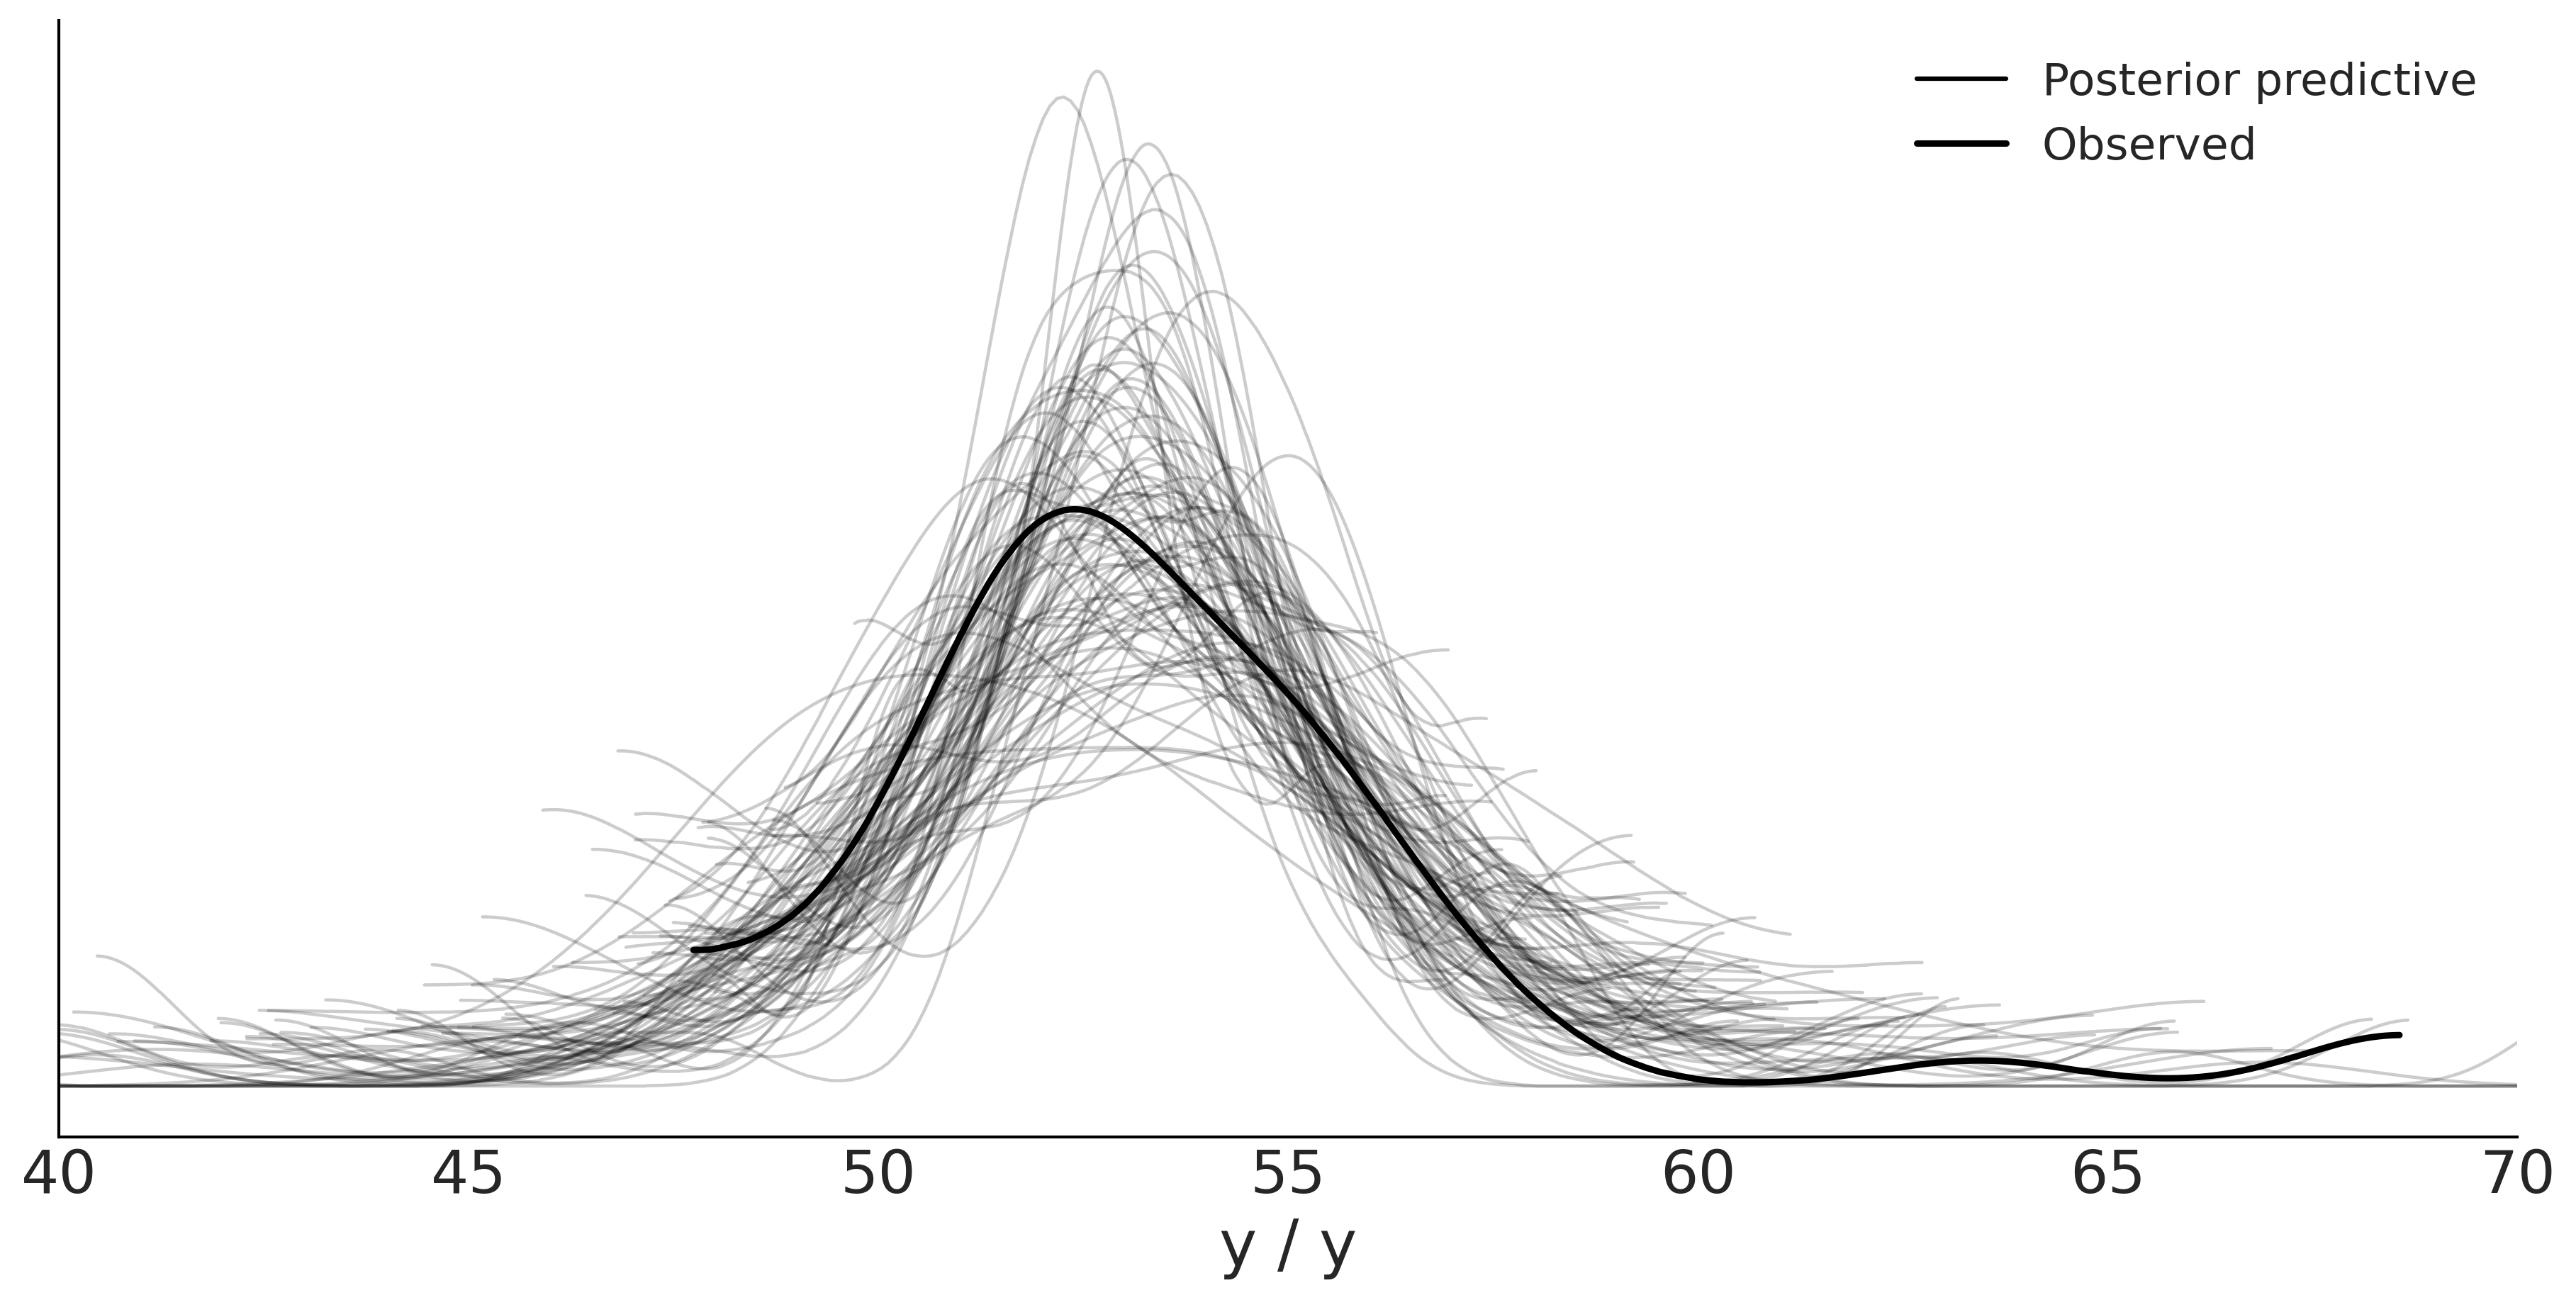

In [33]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True, random_seed=123)
ax= az.plot_ppc(idata_t, figsize=(12, 6), num_pp_samples=100, mean=False)
ax.set_xlim(40, 70)
plt.savefig("../fig/idata_t_ppc.png")

In [35]:
idata_g

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [38]:
posterior = idata_g.posterior

In [44]:
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset>
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 0 2
    draw     int64 0
Data variables:
    μ        (chain) float64 54.01 53.85
    σ        (chain) float64 3.481 2.924
Attributes:
    created_at:                 2023-04-15T16:52:26.763008
    arviz_version:              0.16.0.dev0
    inference_library:          pymc
    inference_library_version:  5.1.2+12.g67925df69
    sampling_time:              1.4225969314575195
    tuning_steps:               1000

In [53]:
posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 53.5
    σ        float64 3.525

In [54]:
posterior.mean("draw")

<xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    μ        (chain) float64 53.52 53.5 53.5 53.49
    σ        (chain) float64 3.527 3.504 3.527 3.542

In [55]:
az.extract(idata_g)

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    μ        (sample) float64 54.01 53.79 53.79 53.55 ... 53.08 54.15 53.23
    σ        (sample) float64 3.481 3.391 3.391 3.453 ... 3.582 4.049 3.262
Attributes:
    created_at:                 2023-04-15T16:52:26.763008
    arviz_version:              0.16.0.dev0
    inference_library:          pymc
    inference_library_version:  5.1.2+12.g67925df69
    sampling_time:              1.4225969314575195
    tuning_steps:               1000

idata

In [26]:
# create exercise student as a mixture of normal distributions
# def student(sigma=100):
#     a = pz.Exponential(sigma).rvs()
#     return pz.Normal(0, a).rvs(200)


# pz.predictive_sliders(student, kind_plot="kde")